# NLP Project #1: Sarcasm Detection with TensorFlow

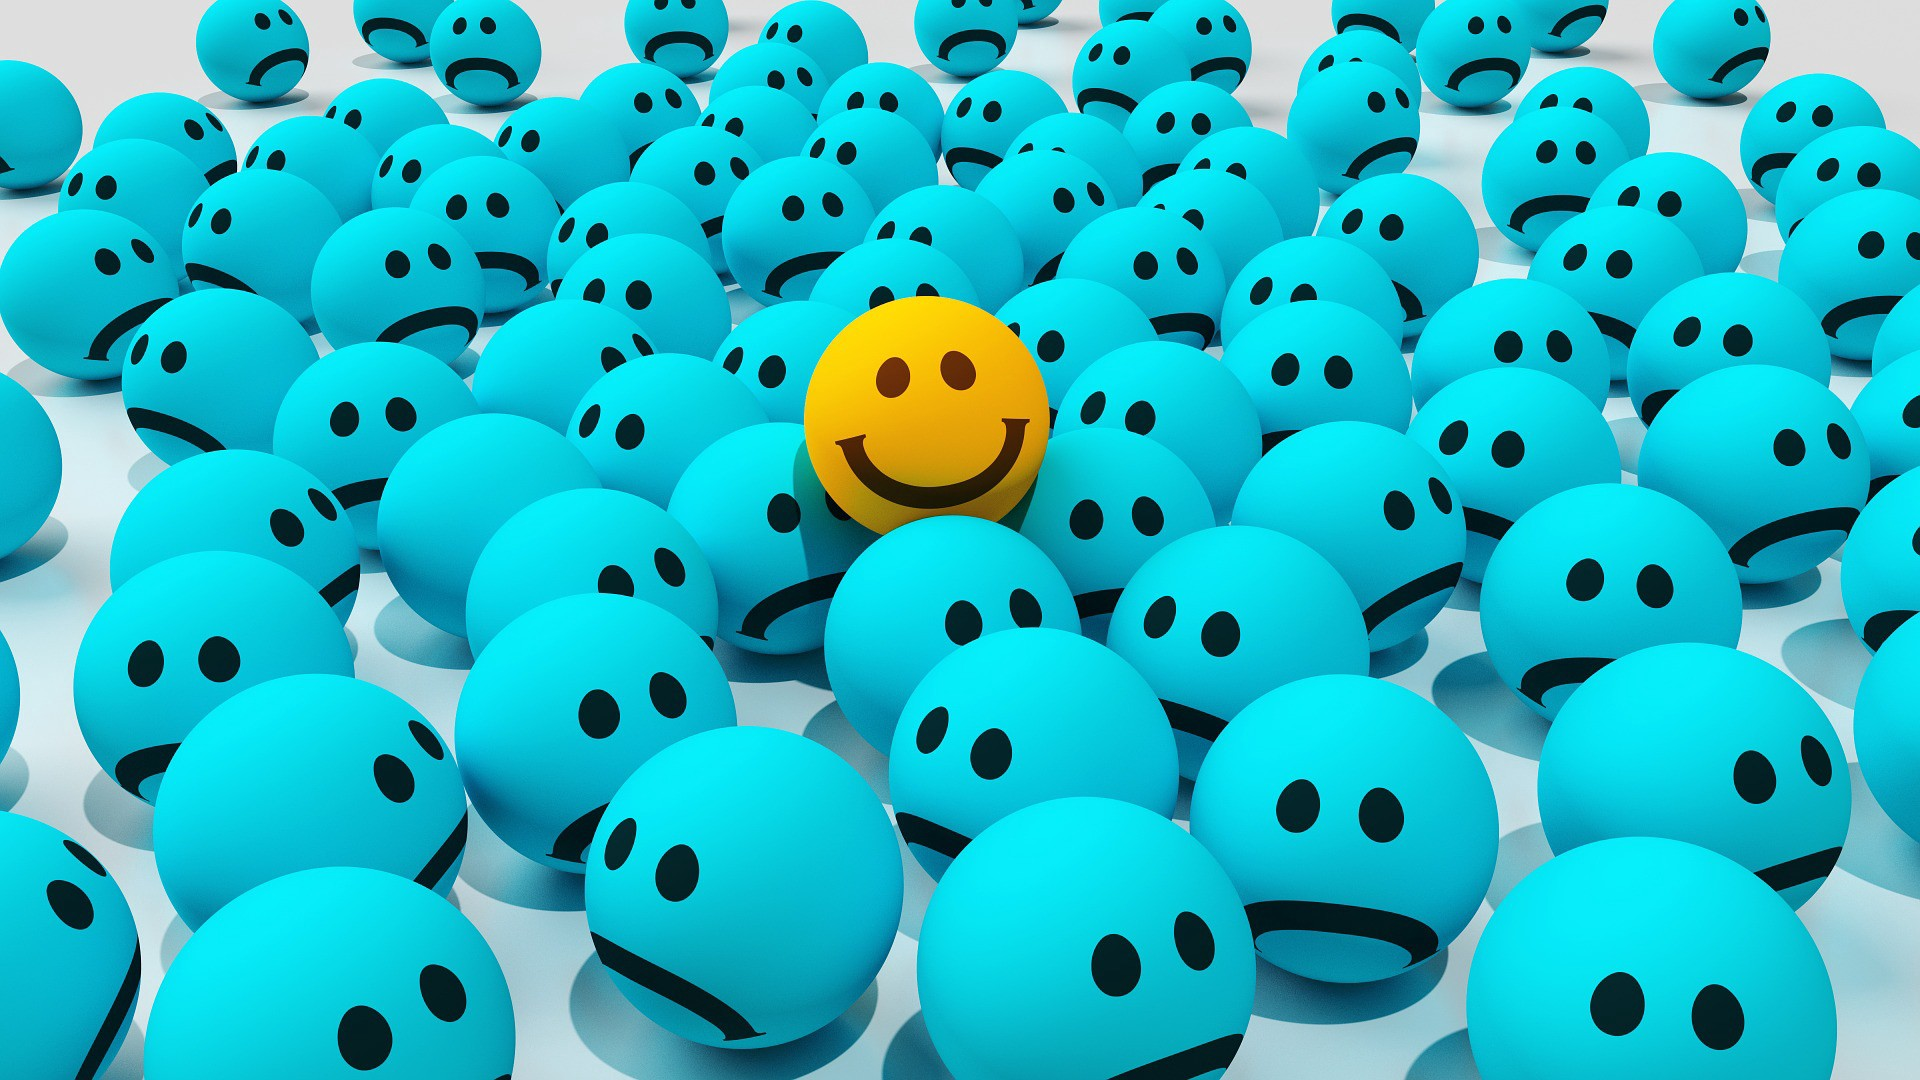

***
### Project Description

In this project I will be building deep learning models using **TensorFlow** framework to detect **sarcasms** in news headlines. The dataset contains real world data as sarcastic news headlines have been scraped from www.theonion.com website while non sarcastic ones have been scraped from news websites such as www.aljazeera.com/, www.nytimes.com/, https://news.sky.com/, www.huffpost.com. There are over **12K** news headlines in the dataset and the target variable is **balanced**. The main evaluation metric for this project to choose the best model is **F1 Score** that measures the balance between **Precision** and **Recall**. I will be coding in **Google Colab**, therefore there might be some indentation differences when viewing the code in IDEs such as **Jupyter Notebook** or **Jupyter Lab**.

***
### Importing Dependencies

In [1]:
from tensorflow.keras.layers import GRU, LSTM, Input, Dense, Conv1D, Flatten, Dropout, MaxPool1D, Embedding, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.models import load_model, clone_model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

from sklearn.metrics import f1_score, roc_curve, recall_score, roc_auc_score, precision_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from google.colab.files import download
from warnings import filterwarnings
from collections import Counter

import matplotlib.pyplot as plt
import tensorflow_hub as hub
import plotly.express as px
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import os

In [2]:
sns.set(style = 'darkgrid', palette = 'bright')
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 8)
filterwarnings(action = 'ignore')

***
### Importing Datasets

In [3]:
# Loading dataset in raw format
raw_data = pd.read_csv(filepath_or_buffer = 'Data.csv')

# Creating a copy of raw dataset
train_df = raw_data.copy()

# Shuffling the dataset
train_df = train_df.sample(frac = 1.0, random_state = 42)
train_df.reset_index(drop = True, inplace = True)

# Displaying the first five records of train dataset
train_df.head()

,headlines,target
0,Chris Cuomo Makes Powerful Appeal To Trump Abo...,Non Sarcastic
1,'Nancy Grace' Is Going Off The Air,Non Sarcastic
2,WATCH: Cooper Defends Beyonce's Lip Syncing,Non Sarcastic
3,Another 800 Evacuated As New River Of Lava Flo...,Non Sarcastic
4,Scientists Receive $10 Million Grant To Melt S...,Sarcastic


***
### Data Preprocessing

Let's create a pie chart and display the portion for each class using train dataset.

In [4]:
px.pie(data_frame = train_df, names = 'target', title = 'Target Variable Balance Check for Train Dataset')

Train dataset is pretty balanced. Let's map the values of **target** variable.

In [5]:
train_df['target'] = train_df['target'].map({'Sarcastic':1, 'Non Sarcastic':0})

Let's split the train dataset into features and labels. In addition, let's also cast the datatype of labels to **float32**.

In [6]:
# Creating features and labels for train dataset
features = train_df.headlines.to_numpy()
labels = train_df.target.to_numpy(dtype = np.float32)

Let's split the features and labels for train dataset into train and validation sets with a ratio of **80%/20%**

In [7]:
# Splitting the train features and labels into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size = 0.2, random_state = 42)

# Displaying the shape of features and labels for train and validation sets
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((10004,), (10004,), (2502,), (2502,))

***
### Modelling: Multinomial Naive Bayes Classifier

Let's create a pipeline for **Multinomial Naive Bayes** model and fit the train data.

In [8]:
model_1 = Pipeline(steps = [('tfidf', TfidfVectorizer()), 
                            ('clf', MultinomialNB())])
model_1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

Let's evaluate the performance of the **Multinomial Naive Bayes** model on train and validation sets.

In [9]:
TRAIN_ACCURACY = model_1.score(X = X_train, y = y_train)
VALID_ACCURACY = model_1.score(X = X_valid, y = y_valid)

print(f'Train accuracy for Multinomial Naive Bayes model: {TRAIN_ACCURACY:.2%}')
print(f'Validation accuracy for Multinomial Naive Bayes model: {VALID_ACCURACY:.2%}')

Train accuracy for Multinomial Naive Bayes model: 95.93%
Validation accuracy for Multinomial Naive Bayes model: 88.69%


Let's define a function to print out the **classification report** for a particular model.

In [10]:
def print_model_report(y_true, y_pred, model_name):
  """
  This is a function that will print out the classification report for a
  particular model.

  Args:
    y_true: Ground truth labels.
    y_pred: Predicted labels.
    model_name: A name of a model.

  Returns:
    Prints out the classification report.
  """
  print(f'Classification report for {model_name} model:\n\n')
  print(classification_report(y_true = y_true, y_pred = y_pred, target_names = ['Non Sarcastic', 'Sarcastic']))

Let's make predictions on validation set and call the function to print out the model performance.

In [11]:
model_1_predictions = model_1.predict(X = X_valid)
print_model_report(y_true = y_valid, y_pred = model_1_predictions, model_name = 'Multinomial Naive Bayes')

Classification report for Multinomial Naive Bayes model:


               precision    recall  f1-score   support

Non Sarcastic       0.88      0.91      0.89      1295
    Sarcastic       0.90      0.86      0.88      1207

     accuracy                           0.89      2502
    macro avg       0.89      0.89      0.89      2502
 weighted avg       0.89      0.89      0.89      2502



Let's define a function to plot a confusion matrix for a particular model.

In [12]:
def plot_confusion_matrix(y_true, y_pred, model_name):
  """
  This is a function that will plot a confusion matrix for a particular model.

  Args:
    y_true: Ground truth labels.
    y_pred: Predicted labels.
    model_name: A name of a model.

  Returns:
    A two-dimensional plot.
  """
  labels = ['Non Sarcastic', 'Sarcastic']
  cm = confusion_matrix(y_true = y_true, y_pred = y_pred)
  upper_stack = cm[0] / np.sum(a = cm, axis = 1)[0]
  lower_stack = cm[1] / np.sum(a = cm, axis = 1)[1]
  final_stack = np.vstack(tup = (upper_stack, lower_stack))

  sns.heatmap(data = final_stack, yticklabels = labels, xticklabels = labels, annot = True, cbar = False, fmt = '.2%', cmap = plt.cm.Blues)
  plt.title(label = f'Confusion Matrix (%) for {model_name} Model', fontsize = 16)
  plt.ylabel(ylabel = 'Groudn Truth Labels', fontsize = 16)
  plt.xlabel(xlabel = 'Predicted Labels', fontsize = 16)
  plt.yticks(fontsize = 14)
  plt.xticks(fontsize = 14)
  plt.show()

Let's call the function and plot the confusion matrix using validation features for **Multinomial Naive Bayes** model. 

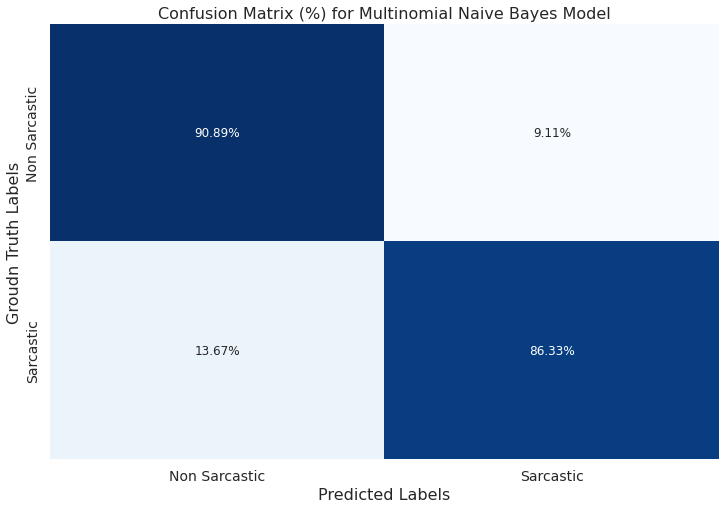

In [13]:
plot_confusion_matrix(y_true = y_valid, y_pred = model_1_predictions, model_name = 'Multinomial Naive Bayes')

Let's evaluate the model performance on validation set using various evaluation metrics such as **Accuracy, F1 Score, Precision, Recall** and **Area Under Curve (AUC) Score**, then store these metrics on a pandas dataframe.

In [14]:
PRECISION_SCORE = precision_score(y_true = y_valid, y_pred = model_1_predictions)
RECALL_SCORE = recall_score(y_true = y_valid, y_pred = model_1_predictions)
F1_SCORE = f1_score(y_true = y_valid, y_pred = model_1_predictions)
AUC_SCORE = roc_auc_score(y_true = y_valid, y_score = model_1_predictions)

COLUMNS = ['Train_Accuracy', 'Validation_Accuracy', 'Precision_Score', 
           'Recall_Score', 'AUC_Score', 'F1_Score']

model_1_df = pd.DataFrame(columns = COLUMNS, index = ['Multinomial Naive Bayes Model'])
model_1_df['Train_Accuracy'] = round(number = TRAIN_ACCURACY, ndigits = 2)
model_1_df['Validation_Accuracy'] = round(number = VALID_ACCURACY, ndigits = 2)
model_1_df['Precision_Score'] = round(number = PRECISION_SCORE, ndigits = 2)
model_1_df['Recall_Score'] = round(number = RECALL_SCORE, ndigits = 2)
model_1_df['AUC_Score'] = round(number = AUC_SCORE, ndigits = 2)
model_1_df['F1_Score'] = round(number = F1_SCORE, ndigits = 2)
model_1_df

,Train_Accuracy,Validation_Accuracy,Precision_Score,Recall_Score,AUC_Score,F1_Score
Multinomial Naive Bayes Model,0.96,0.89,0.9,0.86,0.89,0.88


Let's define a function to count the number of each unique values in the train dataset.

In [15]:
def count_unique_values(text_data):
  """
  This is a function that will count the number of unique values.

  Args:
    text_data: Sentences in train dataset.
  
  Returns:
    A counter object.
  """
  count = Counter()

  for text in text_data:
    for word in text.split():
      count[word] += 1

  return count

Let's call the function and find out the top five most common words in the sentences.

In [16]:
counter = count_unique_values(text_data = features)
print(f'Top five most common words in the sentences: {counter.most_common(n = 5)}')

Top five most common words in the sentences: [('To', 3553), ('Of', 2505), ('In', 1576), ('For', 1471), ('The', 1347)]


Let's create global variables for the **output dimension, vocabulary size** and **average sequence length**.

In [17]:
OUTPUT_DIM = 128
VOCAB_SIZE = len(counter)
AVG_SEQUENCE_LENGTH = round(number = np.mean(a = [len(x.split()) for x in X_train]))

print(f'Arbitrary output dimension: {OUTPUT_DIM}')
print(f'Vocabulary size: {VOCAB_SIZE}')
print(f'Average Sequence Length: {AVG_SEQUENCE_LENGTH}')

Arbitrary output dimension: 128
Vocabulary size: 24717
Average Sequence Length: 10


Let's instantiate a tokenizer and fit the train sentences.

In [18]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token = 'OOV')
tokenizer.fit_on_texts(texts = X_train)

Let's create sequences for train and validation sentences.

In [19]:
train_sequences = tokenizer.texts_to_sequences(texts = X_train)
valid_sequences = tokenizer.texts_to_sequences(texts = X_valid)

Let's create padded sequences for train and validation sequences.

In [20]:
padded_train_sequences = pad_sequences(sequences = train_sequences, maxlen = AVG_SEQUENCE_LENGTH, padding = 'post', truncating = 'post')
padded_valid_sequences = pad_sequences(sequences = valid_sequences, maxlen = AVG_SEQUENCE_LENGTH, padding = 'post', truncating = 'post')

In order to load the data as fast as possibel we are going to use **tf.data** API. Let's create tensor slices for features and labels on train and validation sets. 

In [21]:
# Creating tensor slices for train and validation features
train_features = tf.data.Dataset.from_tensor_slices(tensors = padded_train_sequences)
valid_features = tf.data.Dataset.from_tensor_slices(tensors = padded_valid_sequences)

# Creating tensor slices for train and validation labels
train_labels = tf.data.Dataset.from_tensor_slices(tensors = y_train)
valid_labels = tf.data.Dataset.from_tensor_slices(tensors = y_valid)

Let's zip the features and labels for train, validation and test sets.

In [22]:
# Zipping the features and labels for train and validation sets
train_zipped_dataset = tf.data.Dataset.zip(datasets = (train_features, train_labels))
valid_zipped_dataset = tf.data.Dataset.zip(datasets = (valid_features, valid_labels))

Let's create **prefetch datasets** with **32** batch for train, validation and test sets.

In [23]:
# Creating prefetch datasets with 32 batch for train and validation sets
train_set = train_zipped_dataset.batch(batch_size = 32).prefetch(tf.data.AUTOTUNE)
valid_set = valid_zipped_dataset.batch(batch_size = 32).prefetch(tf.data.AUTOTUNE)

Since we have created a data pipeline to load the data fast and efficiently, let's define a function to create and return a list of callbacks to prevent potential overfitting.

In [24]:
def model_callbacks(model_path, monitoring_metric = 'val_loss', tolerance = 5, verbosity = 1):
  """
  This is a function that will apply an Early Stopping and a Model Checkpoint
  callback to prevent a potential overfitting.

  Args:
    model_path: A path to a model instance.
    monitoring_metric: A metric to monitor during training.
    tolerance: A level of tolerance in case a model does not improve.
    verbosity: A level of verbosity to display an output.

  Returns:
    A list of callbacks.
  """
  stop = EarlyStopping(monitor = monitoring_metric, patience = tolerance, restore_best_weights = True, verbose = verbosity)
  save = ModelCheckpoint(filepath = model_path, monitor = monitoring_metric, save_best_only = True, verbose = verbosity)
  callbacks = [stop, save]
  return callbacks

Let's build a Feed Forward model with **Sequential API**.

In [25]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Creating a Feed Forward model with Sequential API
model_2 = Sequential(layers = [
          Embedding(input_dim = VOCAB_SIZE, output_dim = OUTPUT_DIM, input_length = AVG_SEQUENCE_LENGTH),
          Flatten(),
          Dense(units = 128, activation = 'relu'),
          Dropout(rate = 0.5, seed = 42),
          Dense(units = 128, activation = 'relu'),
          Dropout(rate = 0.5, seed = 42),
          Dense(units = 1, activation = 'sigmoid')
], name = 'Sequential_Feed_Forward')

# Compiling the model
model_2.compile(optimizer = Adam(), loss = BinaryCrossentropy(), metrics = ['accuracy'])

# Fitting the model
model_training_2 = model_2.fit(train_set, epochs = 500, validation_data = valid_set,
                               callbacks = model_callbacks(model_path = f'{model_2.name}.h5'),
                               verbose = 1)

Epoch 1/500
313/313 [==============================] - 6s 8ms/step - loss: 0.3740 - accuracy: 0.8219 - val_loss: 0.2322 - val_accuracy: 0.8973

Epoch 00001: val_loss improved from inf to 0.23216, saving model to Sequential_Feed_Forward.h5
Epoch 2/500
313/313 [==============================] - 2s 7ms/step - loss: 0.0716 - accuracy: 0.9749 - val_loss: 0.2969 - val_accuracy: 0.9021

Epoch 00002: val_loss did not improve from 0.23216
Epoch 3/500
313/313 [==============================] - 2s 7ms/step - loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.3945 - val_accuracy: 0.9013

Epoch 00003: val_loss did not improve from 0.23216
Epoch 4/500
313/313 [==============================] - 2s 7ms/step - loss: 4.8005e-04 - accuracy: 1.0000 - val_loss: 0.4342 - val_accuracy: 0.9049

Epoch 00004: val_loss did not improve from 0.23216
Epoch 5/500
313/313 [==============================] - 2s 7ms/step - loss: 2.1345e-04 - accuracy: 1.0000 - val_loss: 0.4690 - val_accuracy: 0.9045

Epoch 00005: val_loss di

In [26]:
# Displaying the summary of the model
model_2.summary()

Model: "Sequential_Feed_Forward"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 128)           3163776   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)     

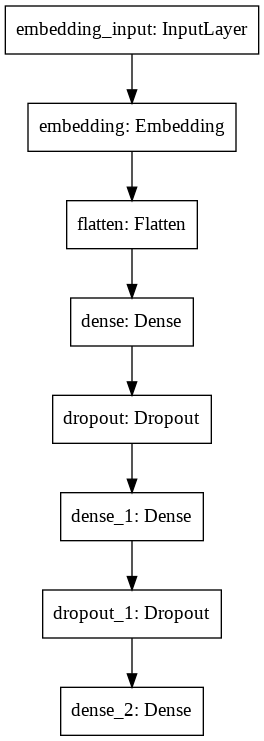

In [27]:
# Displaying the architecture of the model
plot_model(model = model_2, to_file = f'{model_2.name}.png')

Let's define a function to load the best model and evaluate its performance on train and validation sets.

In [28]:
def load_evaluate(model_path, custom_objects = None, transfer_learning = True):
  """
  This is a function that will load the best model and evaluate its performance
  on train and validation sets.

  Args:
    model_path: A path to a model instance.
    custom_objects: A dictionary object to pass an unknown layer.
    transfer_learning: Whether or not a transfer learning has been applied.

  Returns:
    Prints out the model performance on train and validation sets.
  """
  if transfer_learning:
    model = load_model(filepath = model_path, custom_objects = custom_objects)
    model_name = model.name

    train_loss, train_accuracy = model.evaluate(x = X_train, y = y_train, verbose = 0)
    valid_loss, valid_accuracy = model.evaluate(x = X_valid, y = y_valid, verbose = 0)
  else:
    model = load_model(filepath = model_path)  
    model_name = model.name

    train_loss, train_accuracy = model.evaluate(train_set, verbose = 0)
    valid_loss, valid_accuracy = model.evaluate(valid_set, verbose = 0)

  print(f'Train accuracy for {model_name} model: {train_accuracy:.2%}')
  print(f'Validation accuracy for {model_name} model: {valid_accuracy:.2%}\n')
  print(f'Train loss for {model_name} model: {train_loss:.2f}')
  print(f'Validation loss for {model_name} model: {valid_loss:.2f}')

Let's call the function and evaluate the performance of the model on train and  validation sets.

In [29]:
load_evaluate(model_path = f'{model_2.name}.h5', transfer_learning = False)

Train accuracy for Sequential_Feed_Forward model: 97.80%
Validation accuracy for Sequential_Feed_Forward model: 89.73%

Train loss for Sequential_Feed_Forward model: 0.07
Validation loss for Sequential_Feed_Forward model: 0.23


Let's define a function to visualize the performance of a particular model per epoch.

In [30]:
def visualize_performance(history, model_name):
  """
  This is a function that will visualize the performance of a particular model
  per epoch.

  Args:
    history: A history object for a model training.
    model_name: A name of a model.
  
  Returns:
    A two-dimensional plot for accuracy and loss curve.
  """
  valid_acc = history.history['val_accuracy']
  train_acc = history.history['accuracy']

  valid_loss = history.history['val_loss']
  train_loss = history.history['loss']

  plt.figure()
  plt.plot(train_acc, label = 'Train Accuracy', marker = 'o', c = 'darkorange')
  plt.plot(valid_acc, label = 'Valid Accuracy', marker = 'o', c = 'teal')
  plt.title(label = f'{model_name} Model Accuracy Curve', fontsize = 16)
  plt.ylabel(ylabel = 'Accuracy', fontsize = 16)
  plt.xlabel(xlabel = 'Epochs', fontsize = 16)
  plt.legend(loc = 'lower right', fontsize = 16)
  plt.ylim([0.0, 1.05])
  plt.show()

  print()

  plt.figure()
  plt.plot(train_loss, label = 'Train Loss', marker = 'o', c = 'darkorange')
  plt.plot(valid_loss, label = 'Valid Loss', marker = 'o', c = 'teal')
  plt.title(label = f'{model_name} Model Loss Curve', fontsize = 16)
  plt.ylabel(ylabel = 'Loss', fontsize = 16)
  plt.xlabel(xlabel = 'Epochs', fontsize = 16)
  plt.legend(loc = 'best', fontsize = 16)
  plt.show()

Let's call the function and visualize the performance of the model per epoch.

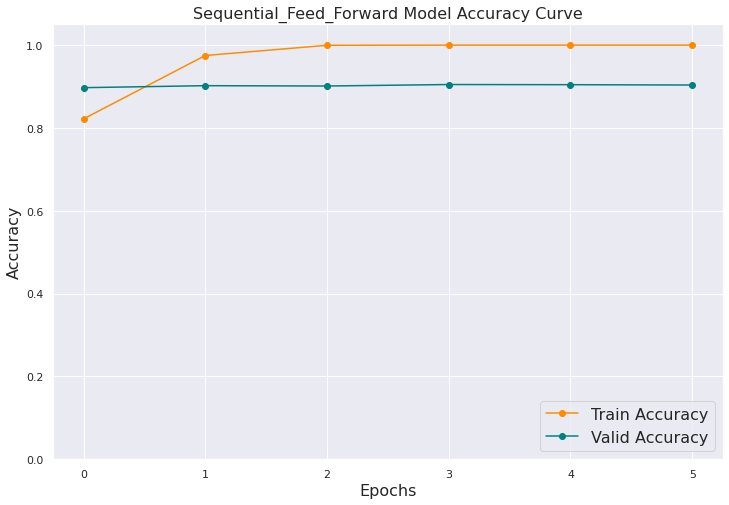

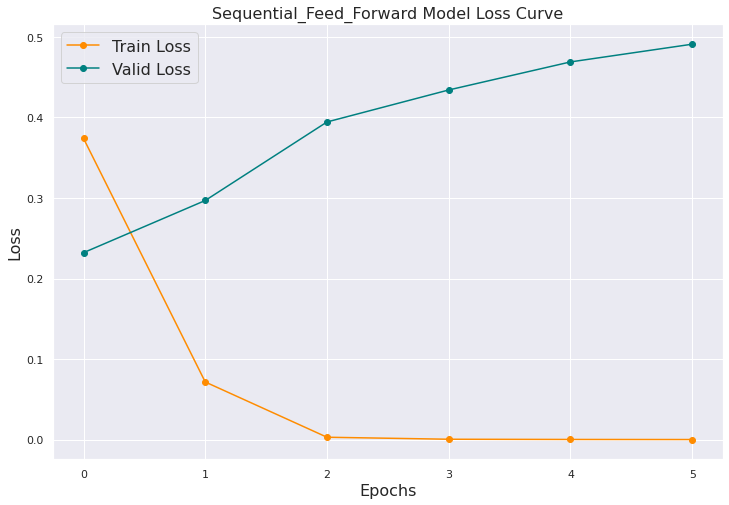

In [31]:
visualize_performance(history = model_training_2, model_name = model_2.name)

Let's load the best model, make predictions on validation set and call the function to print out the model performance.

In [32]:
model_2 = load_model(filepath = f'{model_2.name}.h5')
model_2_predictions = tf.math.round(x = tf.squeeze(input = model_2.predict(x = valid_set))).numpy()
print_model_report(y_true = y_valid, y_pred = model_2_predictions, model_name = model_2.name)

Classification report for Sequential_Feed_Forward model:


               precision    recall  f1-score   support

Non Sarcastic       0.91      0.89      0.90      1295
    Sarcastic       0.88      0.91      0.90      1207

     accuracy                           0.90      2502
    macro avg       0.90      0.90      0.90      2502
 weighted avg       0.90      0.90      0.90      2502



Let's call the function and plot the confusion matrix using validation features.

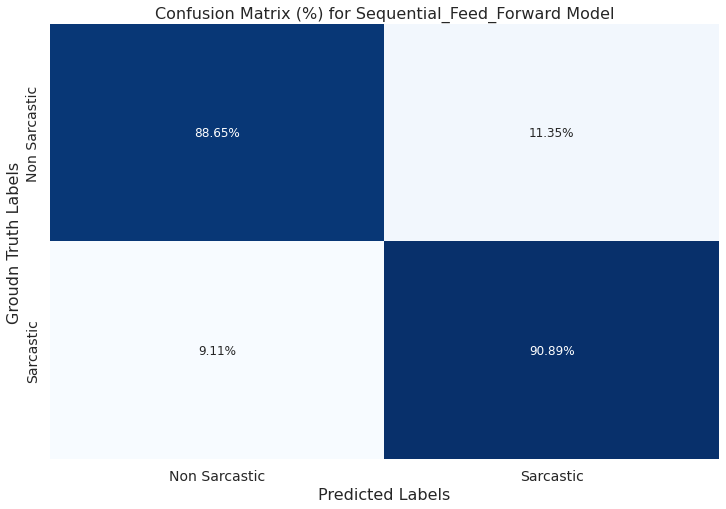

In [33]:
plot_confusion_matrix(y_true = y_valid, y_pred = model_2_predictions, model_name = model_2.name)

Let's define a function to plot **Receiver Operating Characteristics (ROC)** curve to evaluate the performance of a particular model on various probability thresholds.

In [34]:
def plot_roc_curve(y_true, y_pred, validation_data, custom_objects = None, transfer_learning = True, model_path = None):
  """
  This is a function that will plot Receiver Operating Characteristics (ROC)
  curve to to evaluate the performance of a particular model on various 
  probability thresholds.

  Args:
    y_true: Ground truth labels.
    y_pred: Predicted labels.
    validation_data: Validation data to predict probabilities.
    custom_objects: A dictionary object to pass an unknown layer.
    transfer_learning: Whether or not a transfer learning has been applied.
    model_path: A path to a model instance.

  Returns:
    A two-dimensional plot.
  """
  if transfer_learning:
    model = load_model(filepath = model_path, custom_objects = custom_objects)
  else:
    model = load_model(filepath = model_path)
  
  model_name = model.name
  
  fpr, tpr, thresholds = roc_curve(y_true = y_true, y_score = tf.squeeze(input = model.predict(x = validation_data)).numpy())
  auc_score = roc_auc_score(y_true = y_true, y_score = y_pred)

  plt.plot(fpr, tpr, label = f'{model_name} Model AUC Score: {auc_score:.2f}', c = 'darkorange')
  plt.plot([0, 1], [0, 1], label = 'Random Model', c = 'teal')
  plt.title(label = f'ROC Curve for {model_name} Model', fontsize = 16)
  plt.ylabel(ylabel = 'True Positive Rate (RECALL)', fontsize = 16)
  plt.xlabel(xlabel = 'False Positive Rate', fontsize = 16)
  plt.legend(loc = 'lower righ', fontsize = 16)
  plt.xlim([-0.02, 1.0])
  plt.ylim([0.0, 1.05])
  plt.show()

Let's call the function and plot **ROC** curve.

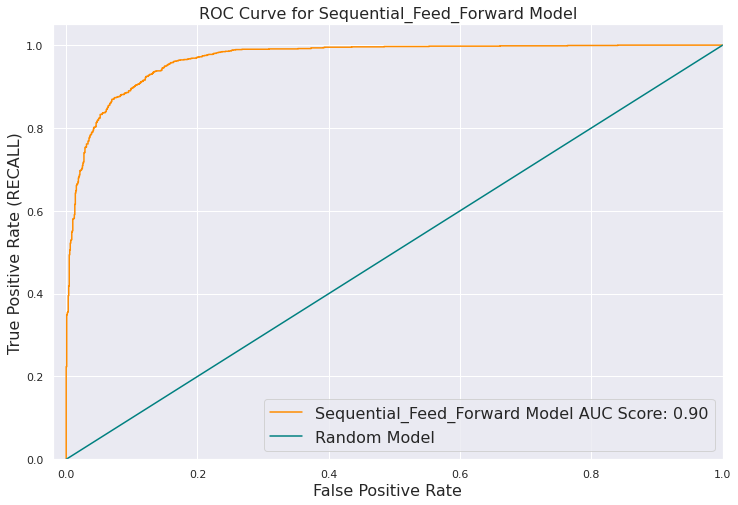

In [35]:
plot_roc_curve(y_true = y_valid, y_pred = model_2_predictions, 
               validation_data = valid_set, transfer_learning = False, 
               model_path = f'{model_2.name}.h5')

Let's define a function to evaluate the performance of a particular model.

In [36]:
def evaluate_model_performance(y_true, y_pred, custom_objects = None, transfer_learning = True, model_path = None):
  """
  This is a function that will evaluate the performance of a particular model
  using various evaluation metrics for a classification problem such as 
  Accuracy, Precision, Recall, F1 Score and AUC.

  Args:
    y_true: Ground truth labels.
    y_pred: Predicted labels.
    custom_objects: A dictionary object to pass an unknown layer.
    transfer_learning: Whether or not a transfer learning has been applied.
    model_path: A path to a model instance.
  
  Returns:
    A pandas dataframe.
  """
  if transfer_learning:
    model = load_model(filepath = model_path, custom_objects = custom_objects)
    model_name = model.name

    _, train_accuracy = model.evaluate(x = X_train, y = y_train, verbose = 0)
    _, valid_accuracy = model.evaluate(x = X_valid, y = y_valid, verbose = 0)
  else:
    model = load_model(filepath = model_path, custom_objects = custom_objects)
    model_name = model.name

    _, train_accuracy = model.evaluate(train_set, verbose = 0)
    _, valid_accuracy = model.evaluate(valid_set, verbose = 0)
    
  precision = precision_score(y_true = y_true, y_pred = y_pred)
  recall = recall_score(y_true = y_true, y_pred = y_pred)
  auc = roc_auc_score(y_true = y_true, y_score = y_pred)
  f1 = f1_score(y_true = y_true, y_pred = y_pred)

  df = pd.DataFrame(columns = COLUMNS, index = [model_name + ' Model'])
  df['Train_Accuracy'] = round(number = train_accuracy, ndigits = 2)
  df['Validation_Accuracy'] = round(number = valid_accuracy, ndigits = 2)
  df['Precision_Score'] = round(number = precision, ndigits = 2)
  df['Recall_Score'] = round(number = recall, ndigits = 2)
  df['AUC_Score'] = round(number = auc, ndigits = 2)
  df['F1_Score'] = round(number = f1, ndigits = 2)
  
  return df

Let's call the function and evaluate the performance of the model.

In [37]:
model_2_df = evaluate_model_performance(y_true = y_valid, y_pred = model_2_predictions, transfer_learning = False, model_path = f'{model_2.name}.h5')
model_2_df

,Train_Accuracy,Validation_Accuracy,Precision_Score,Recall_Score,AUC_Score,F1_Score
Sequential_Feed_Forward Model,0.98,0.9,0.88,0.91,0.9,0.9


Let's build the same model with **Functional API**.

In [38]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Creating a Feed Forward model with Functional API
input_layer = Input(shape = (AVG_SEQUENCE_LENGTH,), name = 'Input_Layer')
x = Embedding(input_dim = VOCAB_SIZE, output_dim = OUTPUT_DIM, input_length = AVG_SEQUENCE_LENGTH)(input_layer)
x = GlobalAveragePooling1D()(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(rate = 0.5, seed = 42)(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(rate = 0.5, seed = 42)(x)
output_layer = Dense(units = 1, activation = 'sigmoid', name = 'Output_Layer')(x)
model_3 = Model(inputs = input_layer, outputs = output_layer, name = 'Functional_Feed_Forward')

# Compiling the model
model_3.compile(optimizer = Adam(), loss = BinaryCrossentropy(), metrics = ['accuracy'])

# Fitting the model
model_training_3 = model_3.fit(train_set, epochs = 500, validation_data = valid_set,
                               callbacks = model_callbacks(model_path = f'{model_3.name}.h5'),
                               verbose = 1)

Epoch 1/500
313/313 [==============================] - 3s 8ms/step - loss: 0.3609 - accuracy: 0.8394 - val_loss: 0.2346 - val_accuracy: 0.9029

Epoch 00001: val_loss improved from inf to 0.23460, saving model to Functional_Feed_Forward.h5
Epoch 2/500
313/313 [==============================] - 2s 8ms/step - loss: 0.1015 - accuracy: 0.9647 - val_loss: 0.3083 - val_accuracy: 0.8993

Epoch 00002: val_loss did not improve from 0.23460
Epoch 3/500
313/313 [==============================] - 2s 8ms/step - loss: 0.0280 - accuracy: 0.9917 - val_loss: 0.3992 - val_accuracy: 0.8953

Epoch 00003: val_loss did not improve from 0.23460
Epoch 4/500
313/313 [==============================] - 2s 8ms/step - loss: 0.0079 - accuracy: 0.9972 - val_loss: 0.5000 - val_accuracy: 0.8889

Epoch 00004: val_loss did not improve from 0.23460
Epoch 5/500
313/313 [==============================] - 2s 8ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.5756 - val_accuracy: 0.8897

Epoch 00005: val_loss did not im

In [39]:
# Displaying the summary of the model
model_3.summary()

Model: "Functional_Feed_Forward"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 10)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 128)           3163776   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)   

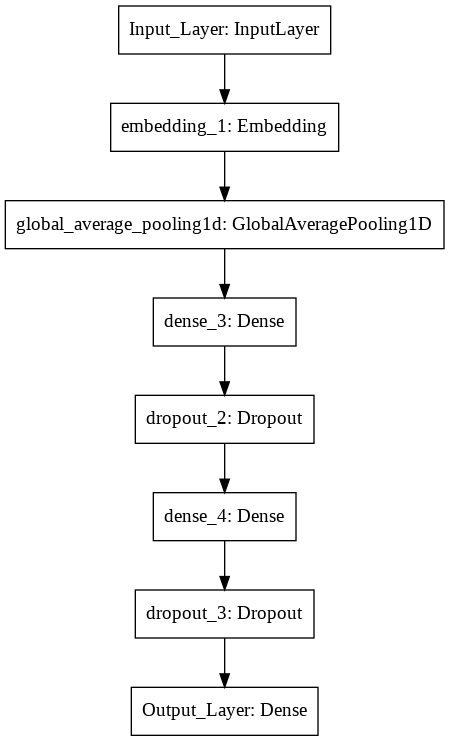

In [40]:
# Displaying the architecture of the model
plot_model(model = model_3, to_file = f'{model_3.name}.png')

Let's load the best model and evaluate its performance on train and validation sets.

In [41]:
load_evaluate(model_path = f'{model_3.name}.h5', transfer_learning = False)

Train accuracy for Functional_Feed_Forward model: 97.06%
Validation accuracy for Functional_Feed_Forward model: 90.29%

Train loss for Functional_Feed_Forward model: 0.10
Validation loss for Functional_Feed_Forward model: 0.23


Let's call the function and visualize the performance of the model per epoch.

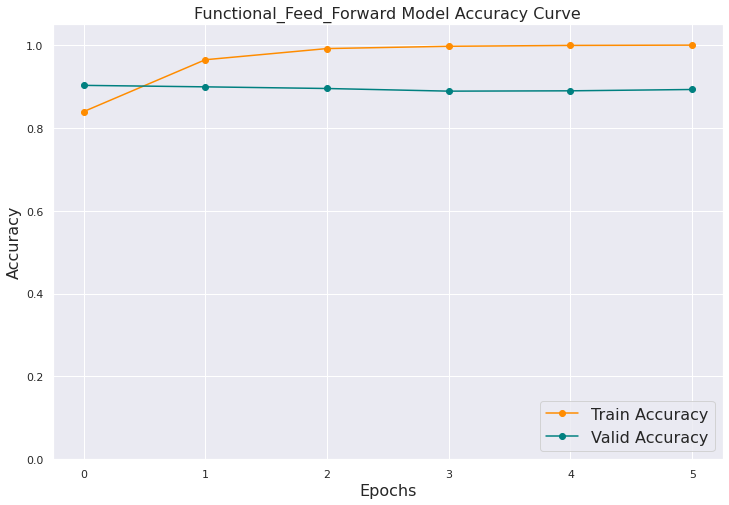

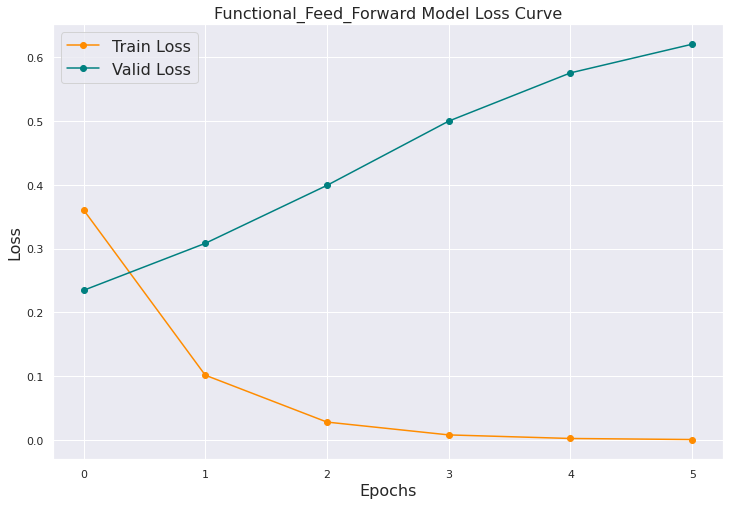

In [42]:
visualize_performance(history = model_training_3, model_name = model_3.name)

Let's load the best model, make predictions on validation set and call the function to print out the model performance.

In [43]:
model_3 = load_model(filepath = f'{model_3.name}.h5')
model_3_predictions = tf.math.round(x = tf.squeeze(input = model_3.predict(x = valid_set))).numpy()
print_model_report(y_true = y_valid, y_pred = model_3_predictions, model_name = model_3.name)

Classification report for Functional_Feed_Forward model:


               precision    recall  f1-score   support

Non Sarcastic       0.93      0.88      0.90      1295
    Sarcastic       0.88      0.93      0.90      1207

     accuracy                           0.90      2502
    macro avg       0.90      0.90      0.90      2502
 weighted avg       0.90      0.90      0.90      2502



Let's call the function and plot the confusion matrix using validation features.

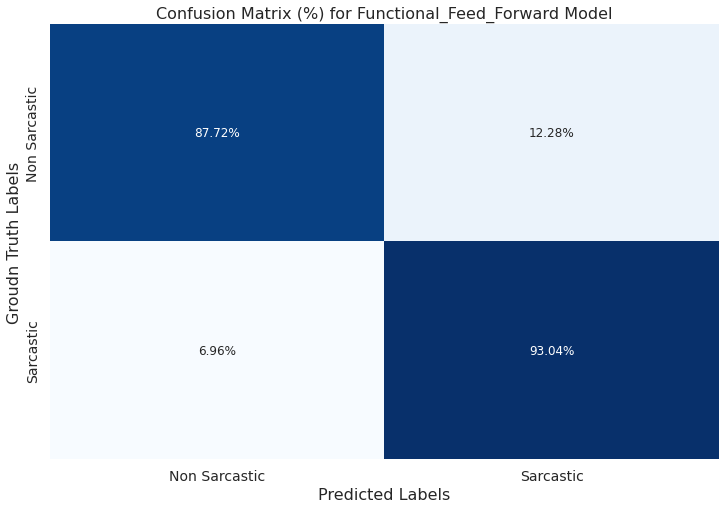

In [44]:
plot_confusion_matrix(y_true = y_valid, y_pred = model_3_predictions, model_name = model_3.name)

Let's call the function and plot ROC curve.

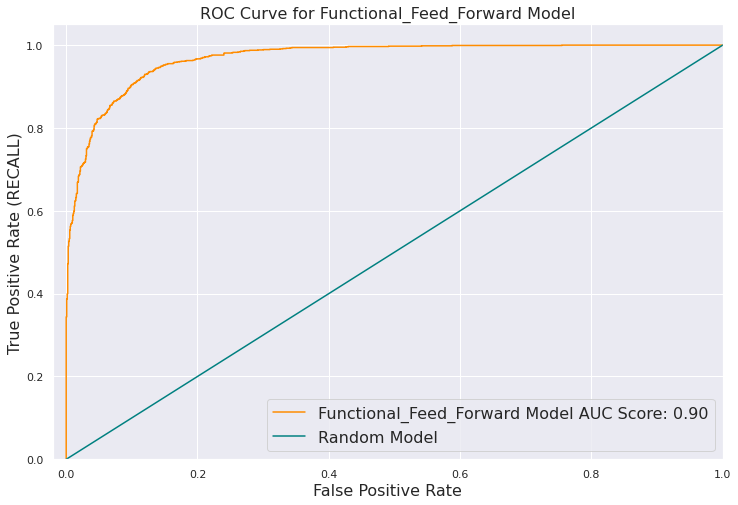

In [45]:
plot_roc_curve(y_true = y_valid, y_pred = model_3_predictions, 
               validation_data = valid_set, transfer_learning = False,
               model_path = f'{model_3.name}.h5')

Let's call the function and evaluate the performance of the model.

In [46]:
model_3_df = evaluate_model_performance(y_true = y_valid, y_pred = model_3_predictions, transfer_learning = False, model_path = f'{model_3.name}.h5')
model_3_df

,Train_Accuracy,Validation_Accuracy,Precision_Score,Recall_Score,AUC_Score,F1_Score
Functional_Feed_Forward Model,0.97,0.9,0.88,0.93,0.9,0.9


Let's build an LSTM model with **Sequential API**.

In [47]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Creating an LSTM model with Sequential API
model_4 = Sequential(layers = [
          Embedding(input_dim = VOCAB_SIZE, output_dim = OUTPUT_DIM, input_length = AVG_SEQUENCE_LENGTH),
          LSTM(units = 64, return_sequences = True),
          LSTM(units = 64),
          Dense(units = 128, activation = 'relu'),
          Dropout(rate = 0.5, seed = 42),
          Dense(units = 128, activation = 'relu'),
          Dropout(rate = 0.5, seed = 42),
          Dense(units = 1, activation = 'sigmoid')
], name = 'LSTM')

# Compiling the model
model_4.compile(optimizer = Adam(), loss = BinaryCrossentropy(), metrics = ['accuracy'])

# Fitting the model
model_training_4 = model_4.fit(train_set, epochs = 500, validation_data = valid_set,
                               callbacks = model_callbacks(model_path = f'{model_4.name}.h5'),
                               verbose = 1)

Epoch 1/500
313/313 [==============================] - 11s 17ms/step - loss: 0.3365 - accuracy: 0.8462 - val_loss: 0.2434 - val_accuracy: 0.9013

Epoch 00001: val_loss improved from inf to 0.24338, saving model to LSTM.h5
Epoch 2/500
313/313 [==============================] - 4s 14ms/step - loss: 0.0912 - accuracy: 0.9701 - val_loss: 0.2685 - val_accuracy: 0.8961

Epoch 00002: val_loss did not improve from 0.24338
Epoch 3/500
313/313 [==============================] - 4s 14ms/step - loss: 0.0219 - accuracy: 0.9937 - val_loss: 0.4554 - val_accuracy: 0.8829

Epoch 00003: val_loss did not improve from 0.24338
Epoch 4/500
313/313 [==============================] - 4s 14ms/step - loss: 0.0115 - accuracy: 0.9968 - val_loss: 0.6524 - val_accuracy: 0.8821

Epoch 00004: val_loss did not improve from 0.24338
Epoch 5/500
313/313 [==============================] - 4s 14ms/step - loss: 0.0163 - accuracy: 0.9952 - val_loss: 0.6439 - val_accuracy: 0.8601

Epoch 00005: val_loss did not improve from 0.

In [48]:
# Displaying the summary of the model
model_4.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 128)           3163776   
_________________________________________________________________
lstm (LSTM)                  (None, 10, 64)            49408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0      

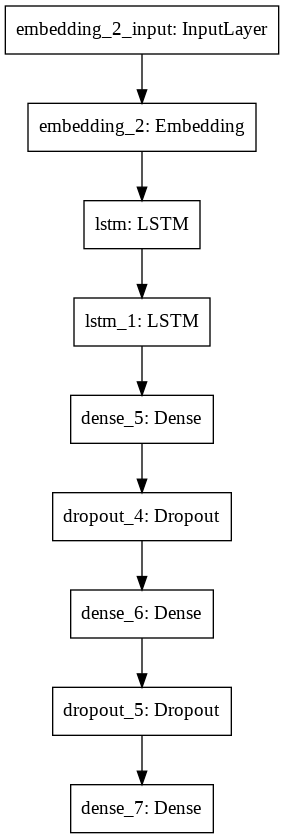

In [49]:
# Displaying the architecture of the model
plot_model(model = model_4, to_file = f'{model_4.name}.png')

Let's load the best model and evaluate its performance on train and validation sets.

In [50]:
load_evaluate(model_path = f'{model_4.name}.h5', transfer_learning = False)

Train accuracy for LSTM model: 96.99%
Validation accuracy for LSTM model: 90.13%

Train loss for LSTM model: 0.12
Validation loss for LSTM model: 0.24


Let's call the function and visualize the performance of the model per epoch.

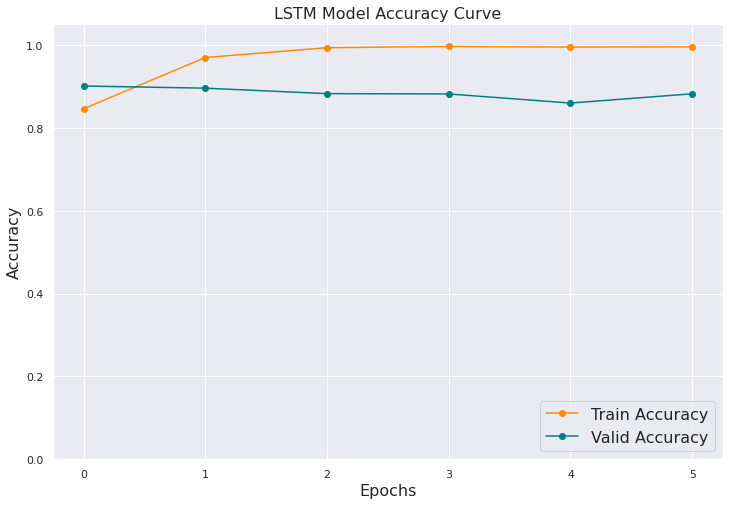

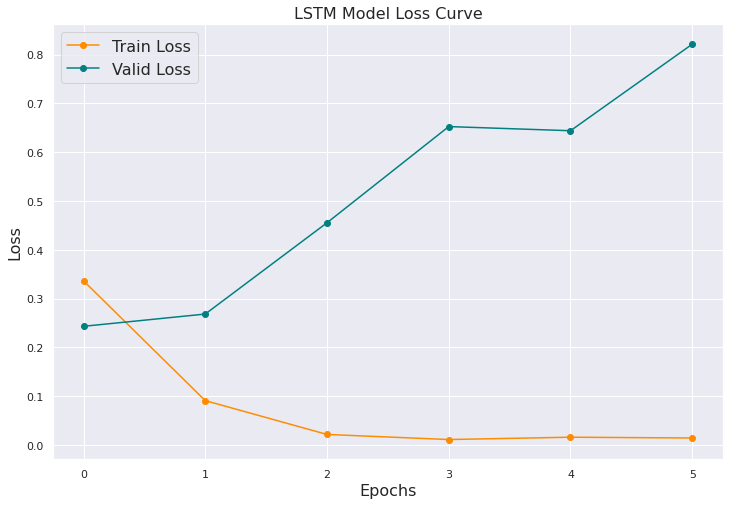

In [51]:
visualize_performance(history = model_training_4, model_name = model_4.name)

Let's load the best model, make predictions on validation set and call the function to print out the model performance.

In [52]:
model_4 = load_model(filepath = f'{model_4.name}.h5')
model_4_predictions = tf.math.round(x = tf.squeeze(input = model_4.predict(x = valid_set))).numpy()
print_model_report(y_true = y_valid, y_pred = model_4_predictions, model_name = model_4.name)

Classification report for LSTM model:


               precision    recall  f1-score   support

Non Sarcastic       0.92      0.88      0.90      1295
    Sarcastic       0.88      0.92      0.90      1207

     accuracy                           0.90      2502
    macro avg       0.90      0.90      0.90      2502
 weighted avg       0.90      0.90      0.90      2502



Let's call the function and plot the confusion matrix using validation features.

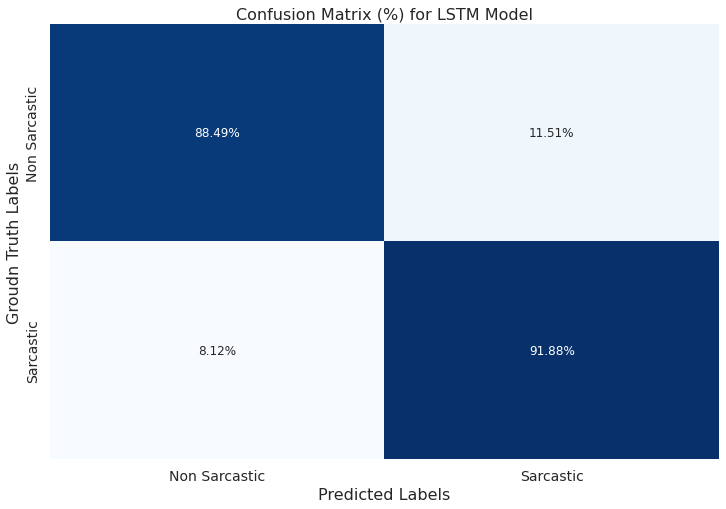

In [53]:
plot_confusion_matrix(y_true = y_valid, y_pred = model_4_predictions, model_name = model_4.name)

Let's call the function and plot ROC curve.

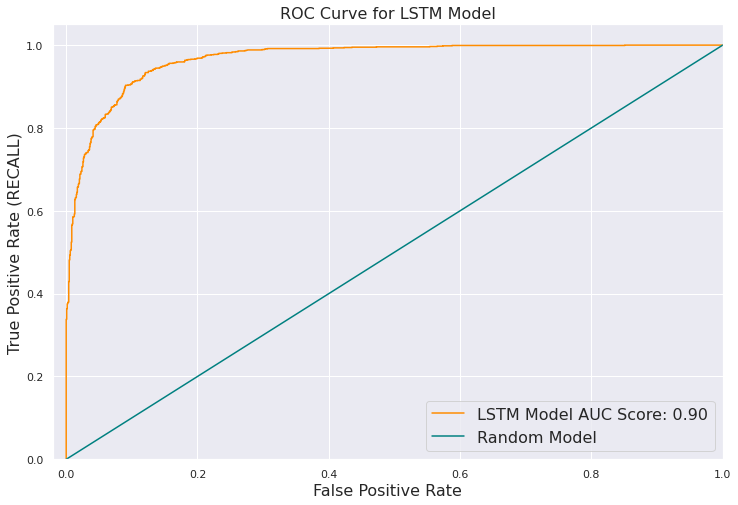

In [54]:
plot_roc_curve(y_true = y_valid, y_pred = model_4_predictions, 
               validation_data = valid_set, transfer_learning = False,
               model_path = f'{model_4.name}.h5')

Let's call the function and evaluate the performance of the model.

In [55]:
model_4_df = evaluate_model_performance(y_true = y_valid, y_pred = model_4_predictions, transfer_learning = False, model_path = f'{model_4.name}.h5')
model_4_df

,Train_Accuracy,Validation_Accuracy,Precision_Score,Recall_Score,AUC_Score,F1_Score
LSTM Model,0.97,0.9,0.88,0.92,0.9,0.9


Let's build a Bidirectional LSTM model with **Functional API**.

In [56]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Creating a Bidirectional LSTM with Functional API
input_layer = Input(shape = (AVG_SEQUENCE_LENGTH,), name = 'Input_Layer')
x = Embedding(input_dim = VOCAB_SIZE, output_dim = OUTPUT_DIM, input_length = AVG_SEQUENCE_LENGTH)(input_layer)
x = Bidirectional(layer = LSTM(units = 64, return_sequences = True))(x)
x = Bidirectional(layer = LSTM(units = 64))(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(rate = 0.5, seed = 42)(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(rate = 0.5, seed = 42)(x)
output_layer = Dense(units = 1, activation = 'sigmoid', name = 'Output_Layer')(x)
model_5 = Model(inputs = input_layer, outputs = output_layer, name = 'Bidirectional_LSTM')

# Compiling the model
model_5.compile(optimizer = Adam(), loss = BinaryCrossentropy(), metrics = ['accuracy'])

# Fitting the model
model_training_5 = model_5.fit(train_set, epochs = 500, validation_data = valid_set,
                               callbacks = model_callbacks(model_path = f'{model_5.name}.h5'),
                               verbose = 1)

Epoch 1/500
313/313 [==============================] - 15s 27ms/step - loss: 0.3306 - accuracy: 0.8501 - val_loss: 0.2343 - val_accuracy: 0.9009

Epoch 00001: val_loss improved from inf to 0.23434, saving model to Bidirectional_LSTM.h5
Epoch 2/500
313/313 [==============================] - 7s 23ms/step - loss: 0.0731 - accuracy: 0.9772 - val_loss: 0.2942 - val_accuracy: 0.8901

Epoch 00002: val_loss did not improve from 0.23434
Epoch 3/500
313/313 [==============================] - 7s 22ms/step - loss: 0.0168 - accuracy: 0.9949 - val_loss: 0.5259 - val_accuracy: 0.8905

Epoch 00003: val_loss did not improve from 0.23434
Epoch 4/500
313/313 [==============================] - 7s 22ms/step - loss: 0.0095 - accuracy: 0.9972 - val_loss: 0.5185 - val_accuracy: 0.8901

Epoch 00004: val_loss did not improve from 0.23434
Epoch 5/500
313/313 [==============================] - 7s 22ms/step - loss: 0.0050 - accuracy: 0.9984 - val_loss: 0.6499 - val_accuracy: 0.8913

Epoch 00005: val_loss did not i

In [57]:
# Displaying the summary of the model
model_5.summary()

Model: "Bidirectional_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 10)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 10, 128)           3163776   
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 128)           98816     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)        

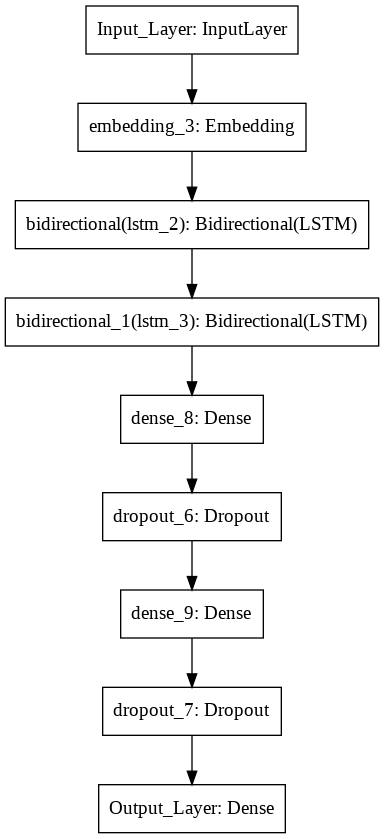

In [58]:
# Displaying the architecture of the model
plot_model(model = model_5, to_file = f'{model_5.name}.png')

Let's load the best model and evaluate its performance on train and validation sets.

In [59]:
load_evaluate(model_path = f'{model_5.name}.h5', transfer_learning = False)

Train accuracy for Bidirectional_LSTM model: 97.70%
Validation accuracy for Bidirectional_LSTM model: 90.09%

Train loss for Bidirectional_LSTM model: 0.11
Validation loss for Bidirectional_LSTM model: 0.23


Let's call the function and visualize the performance of the model per epoch.

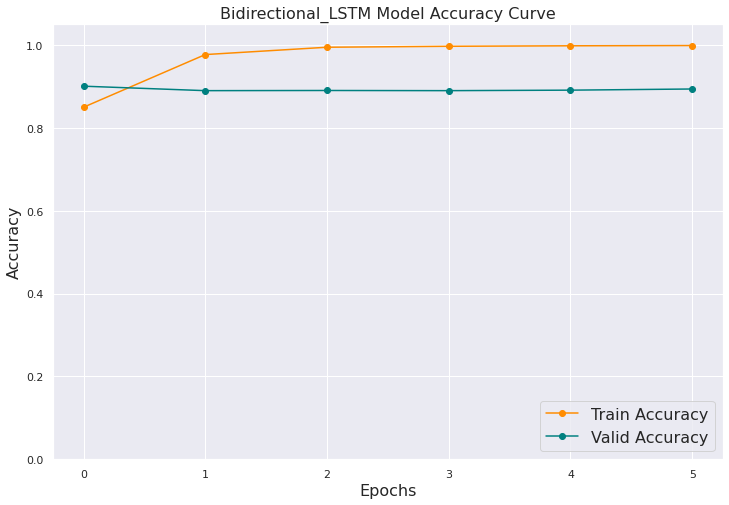

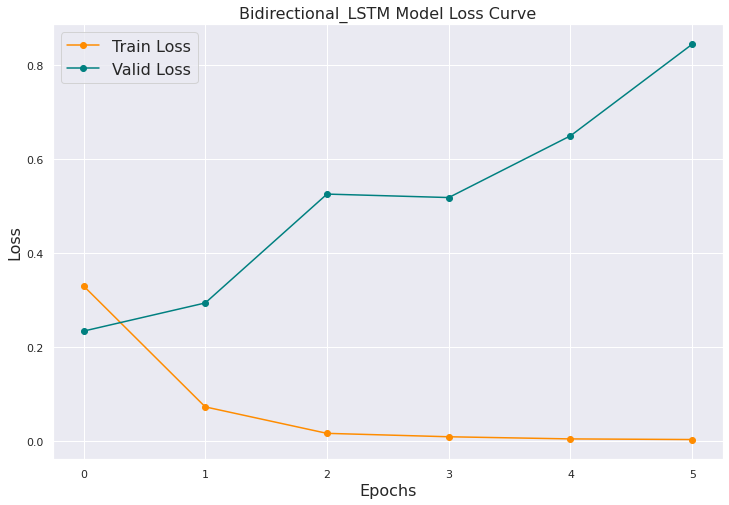

In [60]:
visualize_performance(history = model_training_5, model_name = model_5.name)

Let's load the best model, make predictions on validation set and call the function to print out the model performance.

In [61]:
model_5 = load_model(filepath = f'{model_5.name}.h5')
model_5_predictions = tf.math.round(x = tf.squeeze(input = model_5.predict(x = valid_set))).numpy()
print_model_report(y_true = y_valid, y_pred = model_5_predictions, model_name = model_5.name)

Classification report for Bidirectional_LSTM model:


               precision    recall  f1-score   support

Non Sarcastic       0.92      0.88      0.90      1295
    Sarcastic       0.88      0.92      0.90      1207

     accuracy                           0.90      2502
    macro avg       0.90      0.90      0.90      2502
 weighted avg       0.90      0.90      0.90      2502



Let's call the function and plot the confusion matrix using validation features.

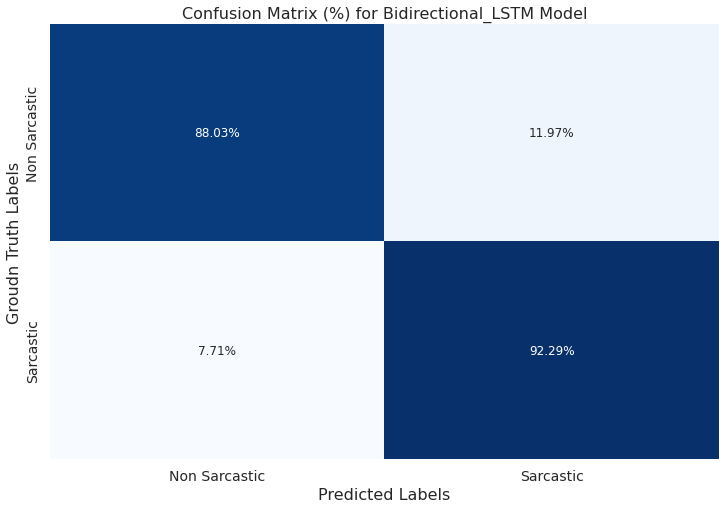

In [62]:
plot_confusion_matrix(y_true = y_valid, y_pred = model_5_predictions, model_name = model_5.name)

Let's call the function and plot ROC curve.

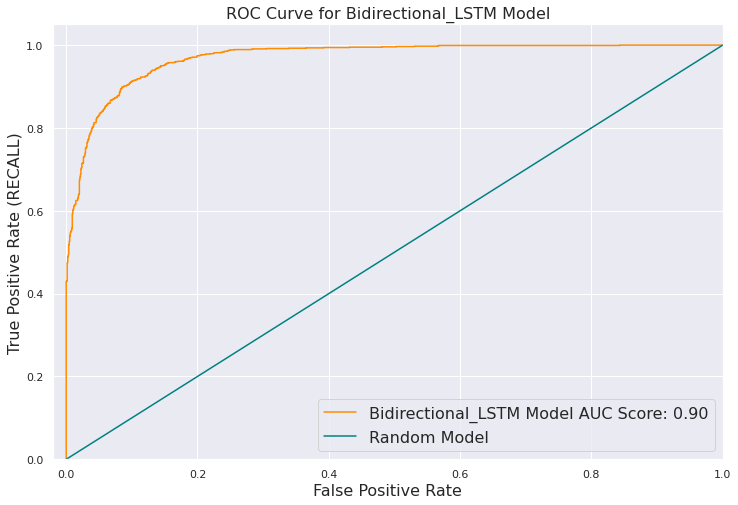

In [63]:
plot_roc_curve(y_true = y_valid, y_pred = model_5_predictions,
               validation_data = valid_set, transfer_learning = False,
               model_path = f'{model_5.name}.h5')

Let's call the function and evaluate the performance of the model.

In [64]:
model_5_df = evaluate_model_performance(y_true = y_valid, y_pred = model_5_predictions, transfer_learning = False, model_path = f'{model_5.name}.h5')
model_5_df

,Train_Accuracy,Validation_Accuracy,Precision_Score,Recall_Score,AUC_Score,F1_Score
Bidirectional_LSTM Model,0.98,0.9,0.88,0.92,0.9,0.9


Let's build a GRU model with **Sequential API**.

In [65]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Creating a GRU model with Sequential API
model_6 = Sequential(layers = [
          Embedding(input_dim = VOCAB_SIZE, output_dim = OUTPUT_DIM, input_length = AVG_SEQUENCE_LENGTH),
          GRU(units = 64, return_sequences = True),
          GRU(units = 64),
          Dense(units = 128, activation = 'relu'),
          Dropout(rate = 0.5, seed = 42),
          Dense(units = 128, activation = 'relu'),
          Dropout(rate = 0.5, seed = 42),
          Dense(units = 1, activation = 'sigmoid')
], name = 'GRU')

# Compiling the model
model_6.compile(optimizer = Adam(), loss = BinaryCrossentropy(), metrics = ['accuracy'])

# Fitting the model
model_training_6 = model_6.fit(train_set, epochs = 500, validation_data = valid_set,
                               callbacks = model_callbacks(model_path = f'{model_6.name}.h5'),
                               verbose = 1)

Epoch 1/500
313/313 [==============================] - 8s 16ms/step - loss: 0.3429 - accuracy: 0.8371 - val_loss: 0.2368 - val_accuracy: 0.9069

Epoch 00001: val_loss improved from inf to 0.23676, saving model to GRU.h5
Epoch 2/500
313/313 [==============================] - 4s 14ms/step - loss: 0.0922 - accuracy: 0.9696 - val_loss: 0.2778 - val_accuracy: 0.8917

Epoch 00002: val_loss did not improve from 0.23676
Epoch 3/500
313/313 [==============================] - 4s 14ms/step - loss: 0.0251 - accuracy: 0.9923 - val_loss: 0.4346 - val_accuracy: 0.8893

Epoch 00003: val_loss did not improve from 0.23676
Epoch 4/500
313/313 [==============================] - 4s 14ms/step - loss: 0.0145 - accuracy: 0.9957 - val_loss: 0.6739 - val_accuracy: 0.8857

Epoch 00004: val_loss did not improve from 0.23676
Epoch 5/500
313/313 [==============================] - 4s 14ms/step - loss: 0.0088 - accuracy: 0.9971 - val_loss: 0.8886 - val_accuracy: 0.8885

Epoch 00005: val_loss did not improve from 0.23

In [66]:
# Displaying the summary of the model
model_6.summary()

Model: "GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 128)           3163776   
_________________________________________________________________
gru (GRU)                    (None, 10, 64)            37248     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0       

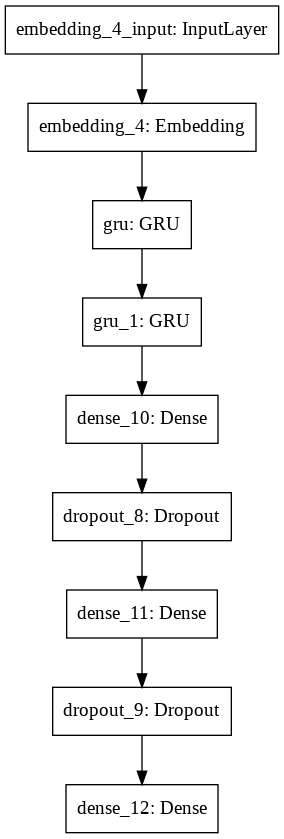

In [67]:
# Displaying the architecture of the model
plot_model(model = model_6, to_file = f'{model_6.name}.png')

Let's load the best model and evaluate its performance on train and validation sets.

In [68]:
load_evaluate(model_path = f'{model_6.name}.h5', transfer_learning = False)

Train accuracy for GRU model: 97.08%
Validation accuracy for GRU model: 90.69%

Train loss for GRU model: 0.11
Validation loss for GRU model: 0.24


Let's call the function and visualize the performance of the model per epoch.

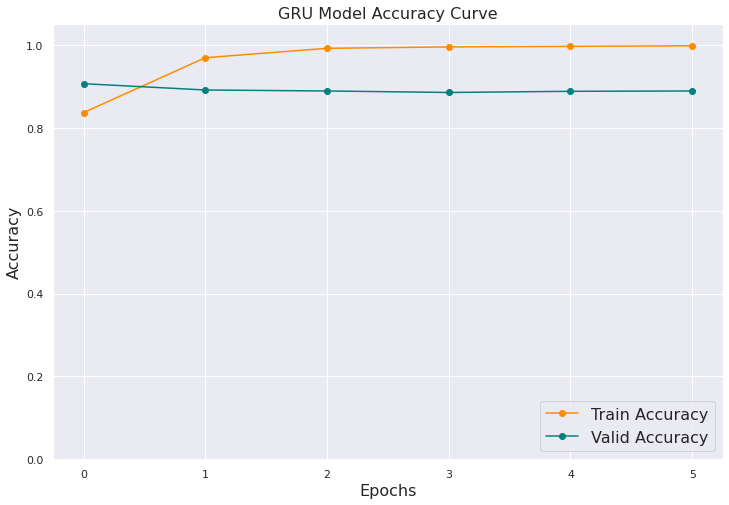

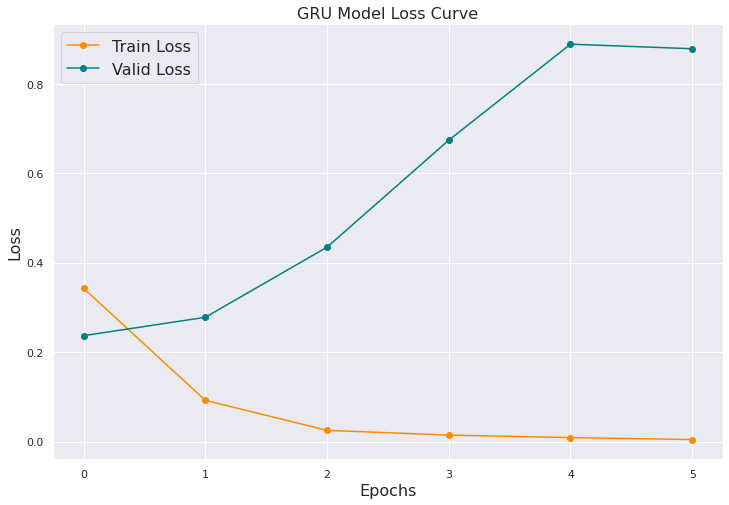

In [69]:
visualize_performance(history = model_training_6, model_name = model_6.name)

Let's load the best model, make predictions on validation set and call the function to print out the model performance.

In [70]:
model_6 = load_model(filepath = f'{model_6.name}.h5')
model_6_predictions = tf.math.round(x = tf.squeeze(input = model_6.predict(x = valid_set))).numpy()
print_model_report(y_true = y_valid, y_pred = model_6_predictions, model_name = model_6.name)

Classification report for GRU model:


               precision    recall  f1-score   support

Non Sarcastic       0.93      0.89      0.91      1295
    Sarcastic       0.89      0.93      0.91      1207

     accuracy                           0.91      2502
    macro avg       0.91      0.91      0.91      2502
 weighted avg       0.91      0.91      0.91      2502



Let's call the function and plot the confusion matrix using validation features.

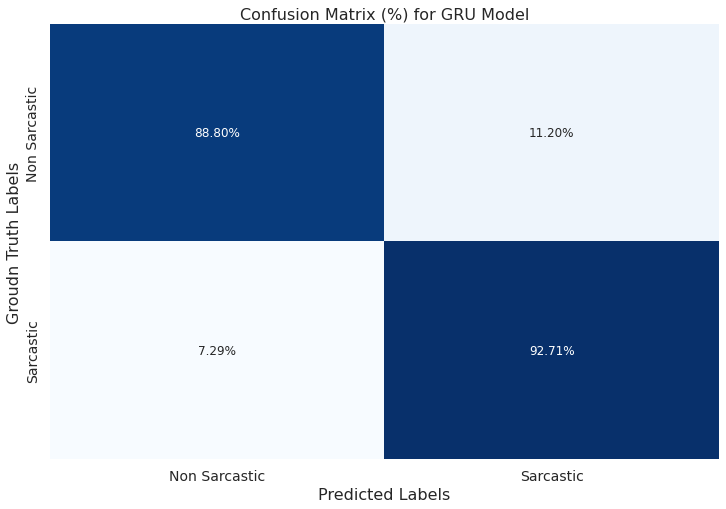

In [71]:
plot_confusion_matrix(y_true = y_valid, y_pred = model_6_predictions, model_name = model_6.name)

Let's call the function and plot ROC curve.

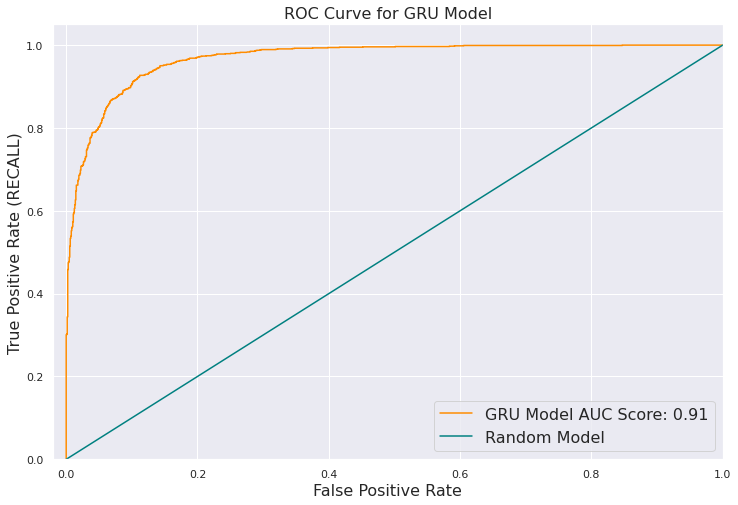

In [72]:
plot_roc_curve(y_true = y_valid, y_pred = model_6_predictions,
               validation_data = valid_set, transfer_learning = False,
               model_path = f'{model_6.name}.h5')

Let's call the function and evaluate the performance of the model.

In [73]:
model_6_df = evaluate_model_performance(y_true = y_valid, y_pred = model_6_predictions, transfer_learning = False, model_path = f'{model_6.name}.h5')
model_6_df

,Train_Accuracy,Validation_Accuracy,Precision_Score,Recall_Score,AUC_Score,F1_Score
GRU Model,0.97,0.91,0.89,0.93,0.91,0.91


Let's build a Bidirectional GRU model with **Functional API**.

In [74]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Creating a Bidirectional GRU model with Functional API
input_layer = Input(shape = (AVG_SEQUENCE_LENGTH,), name = 'Input_Layer')
x = Embedding(input_dim = VOCAB_SIZE, output_dim = OUTPUT_DIM, input_length = AVG_SEQUENCE_LENGTH)(input_layer)
x = Bidirectional(layer = GRU(units = 64, return_sequences = True))(x)
x = Bidirectional(layer = GRU(units = 64))(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(rate = 0.5, seed = 42)(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(rate = 0.5, seed = 42)(x)
output_layer = Dense(units = 1, activation = 'sigmoid', name = 'Output_Layer')(x)
model_7 = Model(inputs = input_layer, outputs = output_layer, name = 'Bidirectional_GRU')

# Compiling the model
model_7.compile(optimizer = Adam(), loss = BinaryCrossentropy(), metrics = ['accuracy'])

# Fitting the model
model_training_7 = model_7.fit(train_set, epochs = 500, validation_data = valid_set,
                               callbacks = model_callbacks(model_path = f'{model_7.name}.h5'),
                               verbose = 1)

Epoch 1/500
313/313 [==============================] - 14s 26ms/step - loss: 0.3303 - accuracy: 0.8498 - val_loss: 0.2347 - val_accuracy: 0.9029

Epoch 00001: val_loss improved from inf to 0.23472, saving model to Bidirectional_GRU.h5
Epoch 2/500
313/313 [==============================] - 7s 21ms/step - loss: 0.0782 - accuracy: 0.9743 - val_loss: 0.3001 - val_accuracy: 0.8925

Epoch 00002: val_loss did not improve from 0.23472
Epoch 3/500
313/313 [==============================] - 7s 22ms/step - loss: 0.0160 - accuracy: 0.9950 - val_loss: 0.5279 - val_accuracy: 0.8913

Epoch 00003: val_loss did not improve from 0.23472
Epoch 4/500
313/313 [==============================] - 7s 21ms/step - loss: 0.0087 - accuracy: 0.9979 - val_loss: 0.6613 - val_accuracy: 0.8941

Epoch 00004: val_loss did not improve from 0.23472
Epoch 5/500
313/313 [==============================] - 7s 21ms/step - loss: 0.0049 - accuracy: 0.9985 - val_loss: 0.7500 - val_accuracy: 0.8941

Epoch 00005: val_loss did not im

In [75]:
# Displaying the summary of the model
model_7.summary()

Model: "Bidirectional_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 10)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 10, 128)           3163776   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 128)           74496     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               74496     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)         

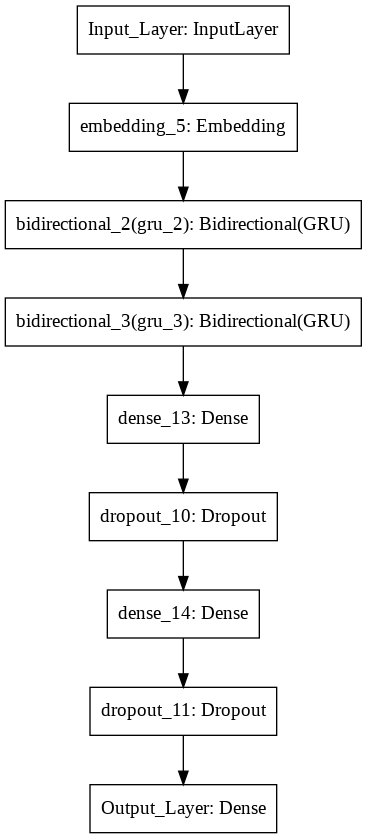

In [76]:
# Displaying the architecture of the model
plot_model(model = model_7, to_file = f'{model_7.name}.png')

Let's load the best model and evaluate its performance on train and validation sets.

In [77]:
load_evaluate(model_path = f'{model_7.name}.h5', transfer_learning = False)

Train accuracy for Bidirectional_GRU model: 97.35%
Validation accuracy for Bidirectional_GRU model: 90.29%

Train loss for Bidirectional_GRU model: 0.11
Validation loss for Bidirectional_GRU model: 0.23


Let's call the function and visualize the performance of the model per epoch.

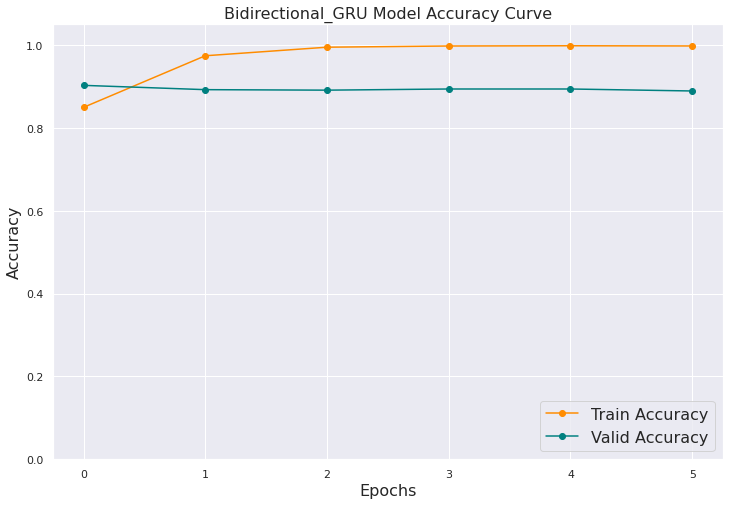

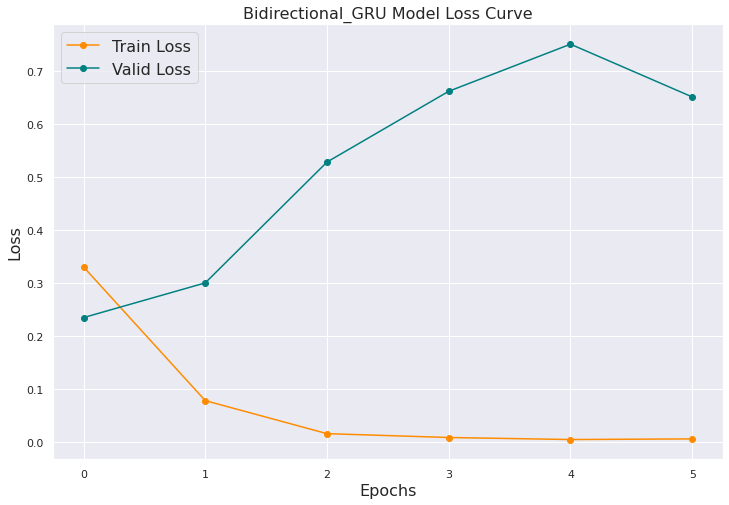

In [78]:
visualize_performance(history = model_training_7, model_name = model_7.name)

Let's load the best model, make predictions on validation set and call the function to print out the model performance.

In [79]:
model_7 = load_model(filepath = f'{model_7.name}.h5')
model_7_predictions = tf.math.round(x = tf.squeeze(input = model_7.predict(x = valid_set))).numpy()
print_model_report(y_true = y_valid, y_pred = model_7_predictions, model_name = model_7.name)

Classification report for Bidirectional_GRU model:


               precision    recall  f1-score   support

Non Sarcastic       0.93      0.88      0.90      1295
    Sarcastic       0.88      0.93      0.90      1207

     accuracy                           0.90      2502
    macro avg       0.90      0.90      0.90      2502
 weighted avg       0.90      0.90      0.90      2502



Let's call the function and plot the confusion matrix using validation features.

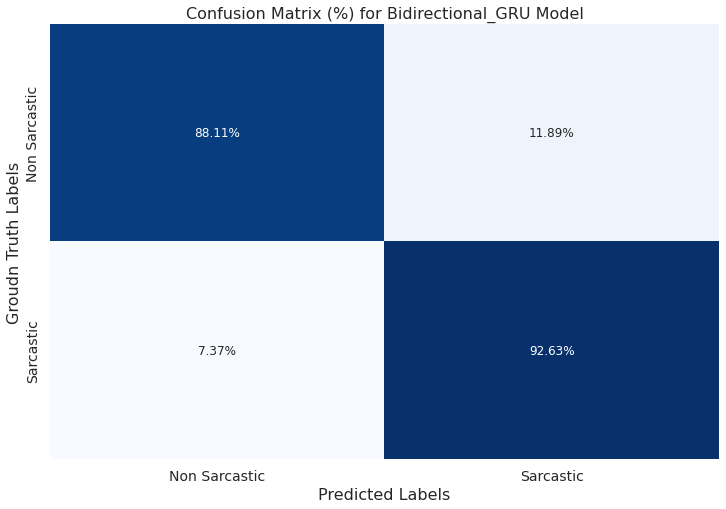

In [80]:
plot_confusion_matrix(y_true = y_valid, y_pred = model_7_predictions, model_name = model_7.name)

Let's call the function and plot ROC curve.

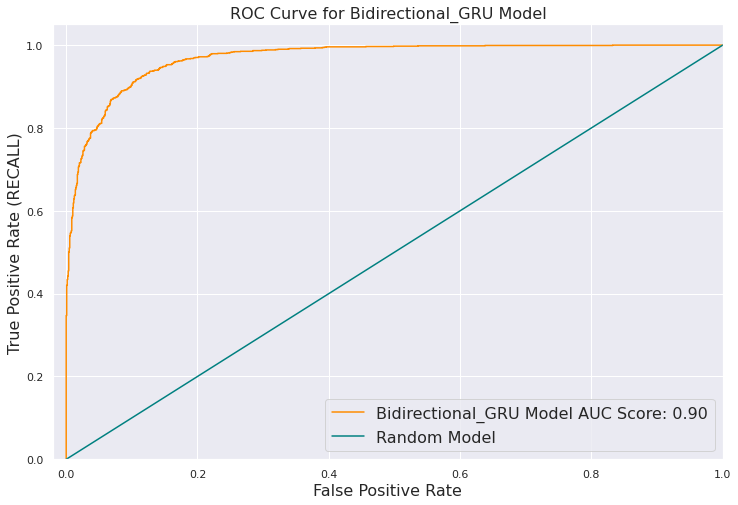

In [81]:
plot_roc_curve(y_true = y_valid, y_pred = model_7_predictions, 
               validation_data = valid_set, transfer_learning = False,
               model_path = f'{model_7.name}.h5')

Let's call the function and evaluate the performance of the model.

In [82]:
model_7_df = evaluate_model_performance(y_true = y_valid, y_pred = model_7_predictions, transfer_learning = False, model_path = f'{model_7.name}.h5')
model_7_df

,Train_Accuracy,Validation_Accuracy,Precision_Score,Recall_Score,AUC_Score,F1_Score
Bidirectional_GRU Model,0.97,0.9,0.88,0.93,0.9,0.9


Let's build a one dimensional Convolutional Neural Network with **Sequential API**.

In [83]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Creating a Conv1D model with Sequential API
model_8 = Sequential(layers = [
          Embedding(input_dim = VOCAB_SIZE, output_dim = OUTPUT_DIM, input_length = AVG_SEQUENCE_LENGTH),
          Conv1D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
          MaxPool1D(padding = 'same'),
          Conv1D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'),
          MaxPool1D(padding = 'same'),
          Flatten(),
          Dense(units = 128, activation = 'relu'),
          Dropout(rate = 0.5, seed = 42),
          Dense(units = 128, activation = 'relu'),
          Dropout(rate = 0.5, seed = 42),
          Dense(units = 1, activation = 'sigmoid')
], name = 'Sequential_Conv1D')

# Compiling the model
model_8.compile(optimizer = Adam(), loss = BinaryCrossentropy(), metrics = ['accuracy'])

# Fitting the model
model_training_8 = model_8.fit(train_set, epochs = 500, validation_data = valid_set,
                               callbacks = model_callbacks(model_path = f'{model_8.name}.h5'),
                               verbose = 1)

Epoch 1/500
313/313 [==============================] - 29s 9ms/step - loss: 0.3855 - accuracy: 0.8047 - val_loss: 0.2409 - val_accuracy: 0.9049

Epoch 00001: val_loss improved from inf to 0.24092, saving model to Sequential_Conv1D.h5
Epoch 2/500
313/313 [==============================] - 3s 9ms/step - loss: 0.0961 - accuracy: 0.9643 - val_loss: 0.3363 - val_accuracy: 0.8909

Epoch 00002: val_loss did not improve from 0.24092
Epoch 3/500
313/313 [==============================] - 3s 8ms/step - loss: 0.0165 - accuracy: 0.9949 - val_loss: 0.5262 - val_accuracy: 0.8945

Epoch 00003: val_loss did not improve from 0.24092
Epoch 4/500
313/313 [==============================] - 3s 9ms/step - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.5900 - val_accuracy: 0.9001

Epoch 00004: val_loss did not improve from 0.24092
Epoch 5/500
313/313 [==============================] - 3s 8ms/step - loss: 0.0041 - accuracy: 0.9985 - val_loss: 0.6923 - val_accuracy: 0.8929

Epoch 00005: val_loss did not improve

In [84]:
# Displaying the summary of the model
model_8.summary()

Model: "Sequential_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 10, 128)           3163776   
_________________________________________________________________
conv1d (Conv1D)              (None, 10, 64)            24640     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 64)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 64)             12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)         

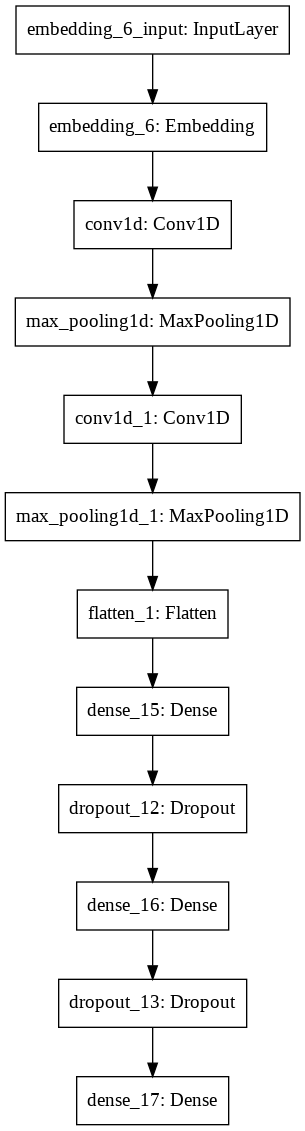

In [85]:
# Displaying the architecture of the model
plot_model(model = model_8, to_file = f'{model_8.name}.png')

Let's load the best model and evaluate its performance on train and validation sets.

In [86]:
load_evaluate(model_path = f'{model_8.name}.h5', transfer_learning = False)

Train accuracy for Sequential_Conv1D model: 96.75%
Validation accuracy for Sequential_Conv1D model: 90.49%

Train loss for Sequential_Conv1D model: 0.11
Validation loss for Sequential_Conv1D model: 0.24


Let's call the function and visualize the performance of the model per epoch.

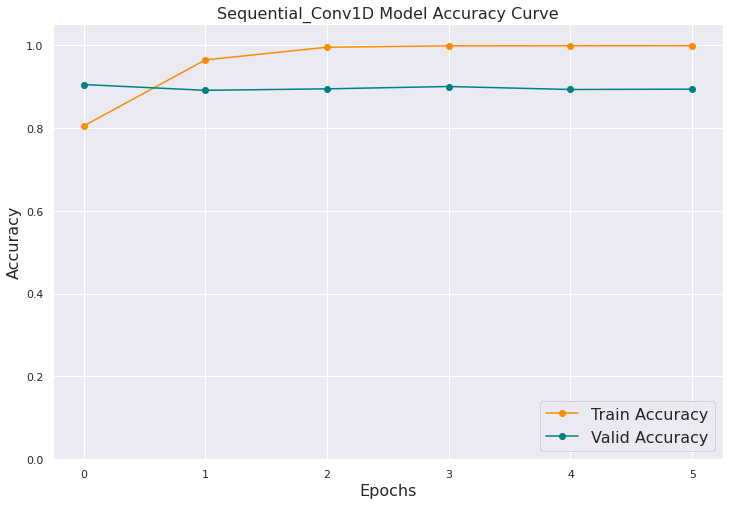

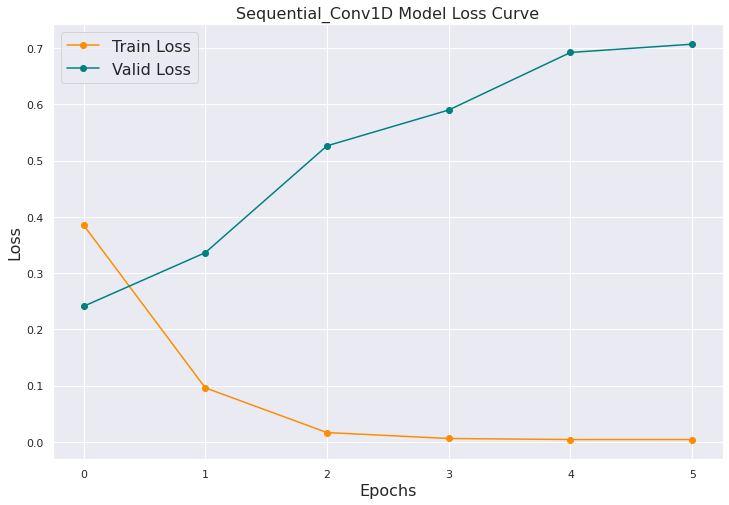

In [87]:
visualize_performance(history = model_training_8, model_name = model_8.name)

Let's load the best model, make predictions on validation set and call the function to print out the model performance.

In [88]:
model_8 = load_model(filepath = f'{model_8.name}.h5')
model_8_predictions = tf.math.round(x = tf.squeeze(input = model_8.predict(x = valid_set))).numpy()
print_model_report(y_true = y_valid, y_pred = model_8_predictions, model_name = model_8.name)

Classification report for Sequential_Conv1D model:


               precision    recall  f1-score   support

Non Sarcastic       0.93      0.88      0.91      1295
    Sarcastic       0.88      0.93      0.90      1207

     accuracy                           0.90      2502
    macro avg       0.91      0.91      0.90      2502
 weighted avg       0.91      0.90      0.90      2502



Let's call the function and plot the confusion matrix using validation features.

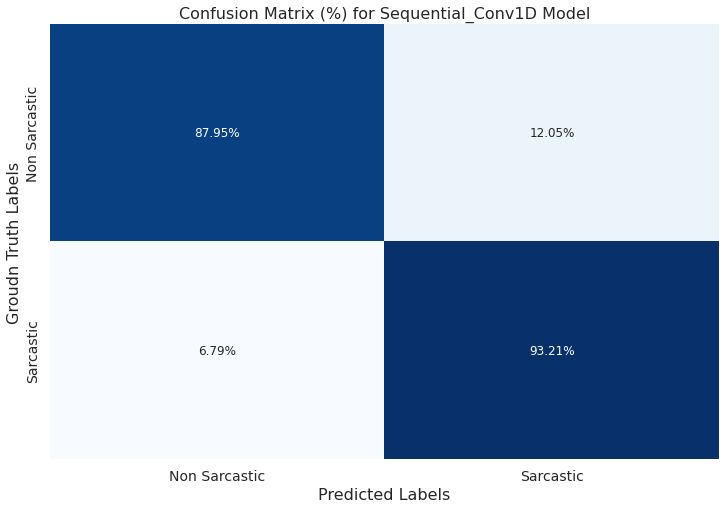

In [89]:
plot_confusion_matrix(y_true = y_valid, y_pred = model_8_predictions, model_name = model_8.name)

Let's call the function and plot ROC curve.

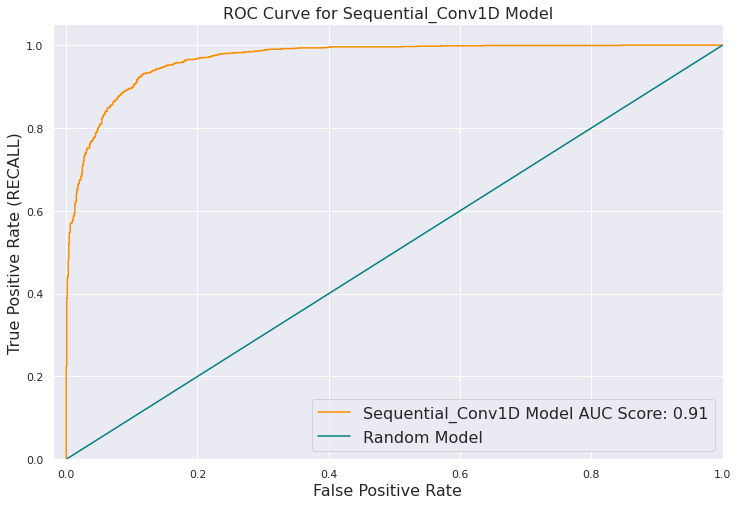

In [90]:
plot_roc_curve(y_true = y_valid, y_pred = model_8_predictions,
               validation_data = valid_set, transfer_learning = False,
               model_path = f'{model_8.name}.h5')

Let's call the function and evaluate the performance of the model.

In [91]:
model_8_df = evaluate_model_performance(y_true = y_valid, y_pred = model_8_predictions, transfer_learning = False, model_path = f'{model_8.name}.h5')
model_8_df

,Train_Accuracy,Validation_Accuracy,Precision_Score,Recall_Score,AUC_Score,F1_Score
Sequential_Conv1D Model,0.97,0.9,0.88,0.93,0.91,0.9


Let's build the same model with **Functional API**.

In [92]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Creating a Conv1D model with Functional API
input_layer = Input(shape = (AVG_SEQUENCE_LENGTH,), name = 'Input_Layer')
x = Embedding(input_dim = VOCAB_SIZE, output_dim = OUTPUT_DIM, input_length = AVG_SEQUENCE_LENGTH)(input_layer)
x = Conv1D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(x)
x = MaxPool1D(padding = 'same')(x)
x = Conv1D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(x)
x = MaxPool1D(padding = 'same')(x)
x = GlobalAveragePooling1D()(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(rate = 0.5, seed = 42)(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(rate = 0.5, seed = 42)(x)
output_layer = Dense(units = 1, activation = 'sigmoid', name = 'Output_Layer')(x)
model_9 = Model(inputs = input_layer, outputs = output_layer, name = 'Functional_Conv1D')

# Compiling the model
model_9.compile(optimizer = Adam(), loss = BinaryCrossentropy(), metrics = ['accuracy'])

# Fitting the model
model_training_9 = model_9.fit(train_set, epochs = 500, validation_data = valid_set,
                               callbacks = model_callbacks(model_path = f'{model_9.name}.h5'),
                               verbose = 1)

Epoch 1/500
313/313 [==============================] - 4s 9ms/step - loss: 0.3830 - accuracy: 0.8101 - val_loss: 0.2454 - val_accuracy: 0.9013

Epoch 00001: val_loss improved from inf to 0.24541, saving model to Functional_Conv1D.h5
Epoch 2/500
313/313 [==============================] - 3s 9ms/step - loss: 0.0998 - accuracy: 0.9658 - val_loss: 0.3204 - val_accuracy: 0.8929

Epoch 00002: val_loss did not improve from 0.24541
Epoch 3/500
313/313 [==============================] - 3s 9ms/step - loss: 0.0177 - accuracy: 0.9953 - val_loss: 0.4730 - val_accuracy: 0.8965

Epoch 00003: val_loss did not improve from 0.24541
Epoch 4/500
313/313 [==============================] - 3s 9ms/step - loss: 0.0055 - accuracy: 0.9985 - val_loss: 0.6908 - val_accuracy: 0.8957

Epoch 00004: val_loss did not improve from 0.24541
Epoch 5/500
313/313 [==============================] - 3s 9ms/step - loss: 0.0078 - accuracy: 0.9978 - val_loss: 0.6309 - val_accuracy: 0.8897

Epoch 00005: val_loss did not improve 

In [93]:
# Displaying the summary of the model
model_9.summary()

Model: "Functional_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 10)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 10, 128)           3163776   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 64)            24640     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 64)             12352     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)          

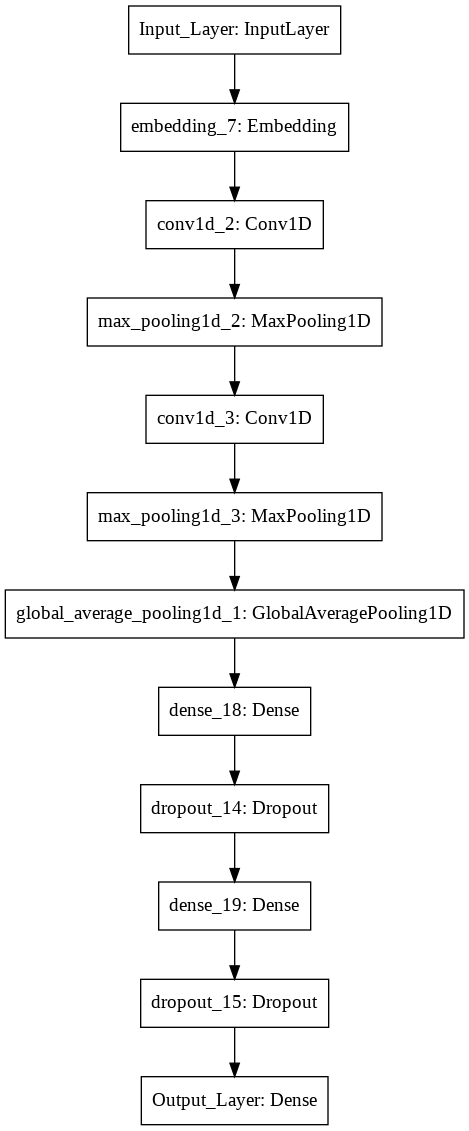

In [94]:
# Displaying the architecture of the model
plot_model(model = model_9, to_file = f'{model_9.name}.png')

Let's load the best model and evaluate its performance on train and validation sets.

In [95]:
load_evaluate(model_path = f'{model_9.name}.h5', transfer_learning = False)

Train accuracy for Functional_Conv1D model: 96.49%
Validation accuracy for Functional_Conv1D model: 90.13%

Train loss for Functional_Conv1D model: 0.12
Validation loss for Functional_Conv1D model: 0.25


Let's call the function and visualize the performance of the model per epoch.

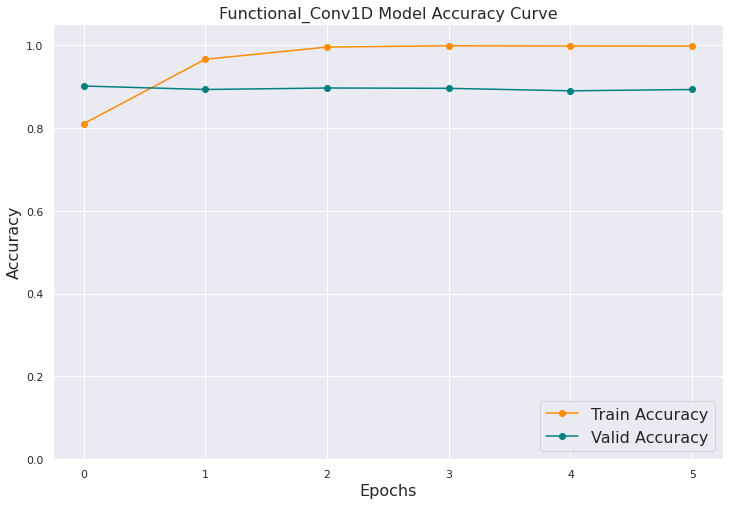

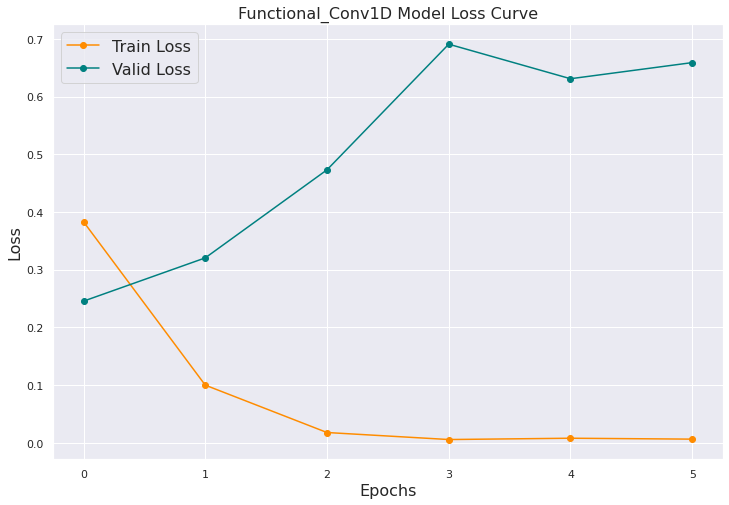

In [96]:
visualize_performance(history = model_training_9, model_name = model_9.name)

Let's load the best model, make predictions on validation set and call the function to print out the model performance.

In [97]:
model_9 = load_model(filepath = f'{model_9.name}.h5')
model_9_predictions = tf.math.round(x = tf.squeeze(input = model_9.predict(x = valid_set))).numpy()
print_model_report(y_true = y_valid, y_pred = model_9_predictions, model_name = model_9.name)

Classification report for Functional_Conv1D model:


               precision    recall  f1-score   support

Non Sarcastic       0.93      0.88      0.90      1295
    Sarcastic       0.88      0.93      0.90      1207

     accuracy                           0.90      2502
    macro avg       0.90      0.90      0.90      2502
 weighted avg       0.90      0.90      0.90      2502



Let's call the function and plot the confusion matrix using validation features.

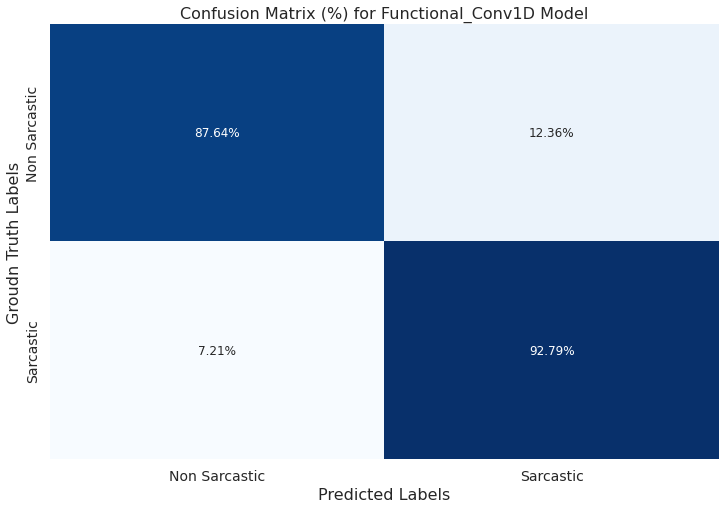

In [98]:
plot_confusion_matrix(y_true = y_valid, y_pred = model_9_predictions, model_name = model_9.name)

Let's call the function and plot ROC curve.

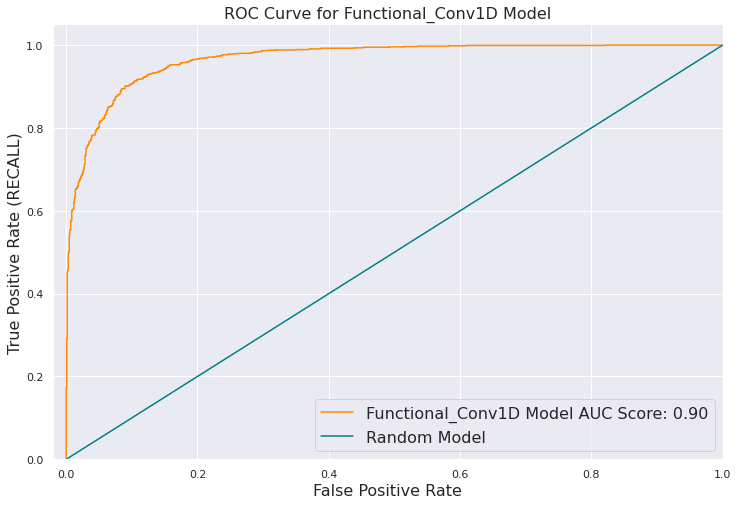

In [99]:
plot_roc_curve(y_true = y_valid, y_pred = model_9_predictions,
               validation_data = valid_set, transfer_learning = False,
               model_path = f'{model_9.name}.h5')

Let's call the function and evaluate the performance of the model.

In [100]:
model_9_df = evaluate_model_performance(y_true = y_valid, y_pred = model_9_predictions, transfer_learning = False, model_path = f'{model_9.name}.h5')
model_9_df

,Train_Accuracy,Validation_Accuracy,Precision_Score,Recall_Score,AUC_Score,F1_Score
Functional_Conv1D Model,0.96,0.9,0.88,0.93,0.9,0.9


Let's instantiate **Universal Sentence Encoder (USE)**.

In [101]:
use_encoder_layer = hub.KerasLayer(handle = 'https://tfhub.dev/google/universal-sentence-encoder/4', name = 'USE_Layer')

Let's build a model with USE layer using **Functional API**.

In [102]:
# Setting global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Creating a model with USE layer using Functional API
input_layer = Input(shape = (), dtype = tf.string, name = 'Input_Layer')
x = use_encoder_layer(input_layer)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(rate = 0.5, seed = 42)(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(rate = 0.5, seed = 42)(x)
output_layer = Dense(units = 1, activation = 'sigmoid', name = 'Output_Layer')(x)
model_10 = Model(inputs = input_layer, outputs = output_layer, name = 'USE')

# Compiling the model
model_10.compile(optimizer = Adam(), loss = BinaryCrossentropy(), metrics = ['accuracy'])

# Fitting the model
model_training_10 = model_10.fit(x = X_train, y = y_train, batch_size = 32,
                                 epochs = 500, validation_data = (X_valid, y_valid),
                                 callbacks = model_callbacks(model_path = f'{model_10.name}.h5'),
                                 verbose = 1)

Epoch 1/500
313/313 [==============================] - 9s 21ms/step - loss: 0.3795 - accuracy: 0.8347 - val_loss: 0.2958 - val_accuracy: 0.8749

Epoch 00001: val_loss improved from inf to 0.29575, saving model to USE.h5
Epoch 2/500
313/313 [==============================] - 6s 19ms/step - loss: 0.2845 - accuracy: 0.8799 - val_loss: 0.2817 - val_accuracy: 0.8793

Epoch 00002: val_loss improved from 0.29575 to 0.28169, saving model to USE.h5
Epoch 3/500
313/313 [==============================] - 6s 19ms/step - loss: 0.2594 - accuracy: 0.8922 - val_loss: 0.2774 - val_accuracy: 0.8829

Epoch 00003: val_loss improved from 0.28169 to 0.27744, saving model to USE.h5
Epoch 4/500
313/313 [==============================] - 6s 20ms/step - loss: 0.2362 - accuracy: 0.9048 - val_loss: 0.2730 - val_accuracy: 0.8853

Epoch 00004: val_loss improved from 0.27744 to 0.27302, saving model to USE.h5
Epoch 5/500
313/313 [==============================] - 6s 19ms/step - loss: 0.2124 - accuracy: 0.9146 - val_

In [103]:
# Displaying the summary of the model
model_10.summary()

Model: "USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None,)]                 0         
_________________________________________________________________
USE_Layer (KerasLayer)       (None, 512)               256797824 
_________________________________________________________________
dense_20 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
Output_Layer (Dense)         (None, 1)                 129     

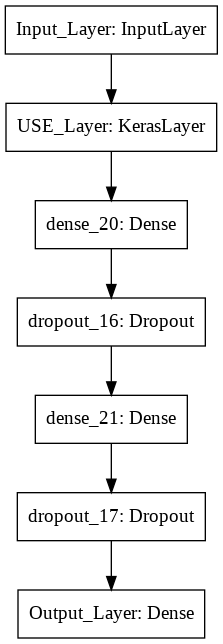

In [104]:
# Displaying the architecture of the model
plot_model(model = model_10, to_file = f'{model_10.name}.png')

Let's create an instance for custom objects to pass the Keras Layer when loading the model.

In [105]:
CUSTOM_OBJECTS = {'KerasLayer':hub.KerasLayer}

Let's load the best model and evaluate its performance on train and validation sets.

In [106]:
load_evaluate(model_path = f'{model_10.name}.h5', custom_objects = CUSTOM_OBJECTS)

Train accuracy for USE model: 92.71%
Validation accuracy for USE model: 88.53%

Train loss for USE model: 0.19
Validation loss for USE model: 0.27


Let's call the function and visualize the performance of the model per epoch.

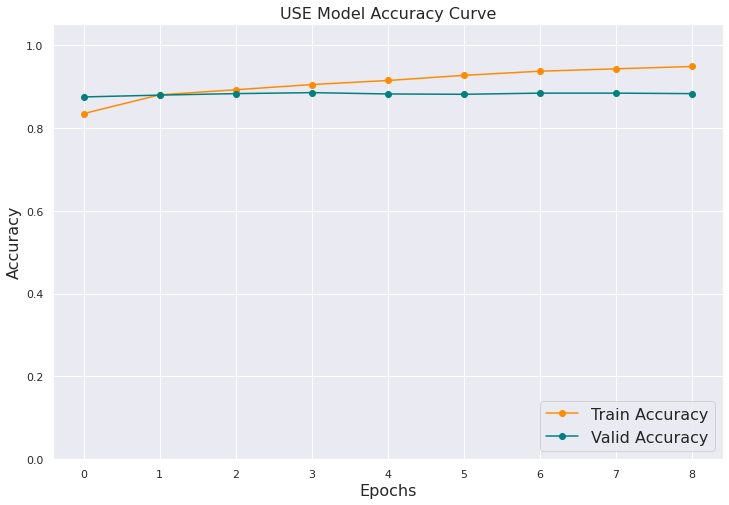

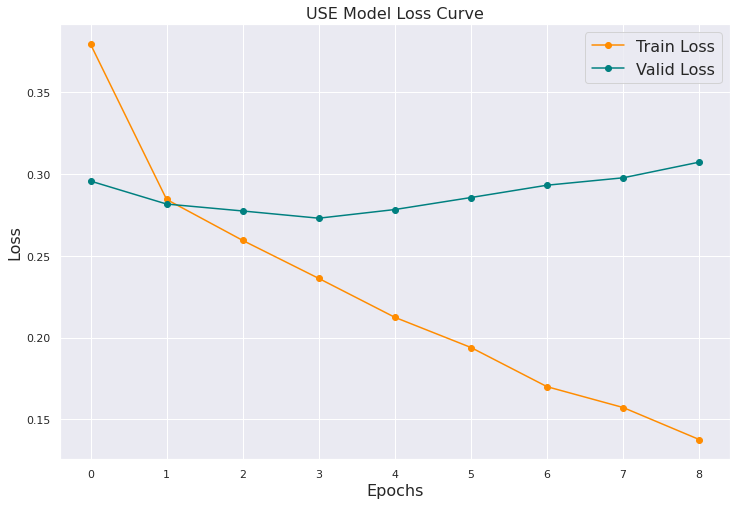

In [107]:
visualize_performance(history = model_training_10, model_name = model_10.name)

Let's load the best model, make predictions on validation set and call the function to print out the model performance.

In [108]:
model_10 = load_model(filepath = f'{model_10.name}.h5', custom_objects = CUSTOM_OBJECTS)
model_10_predictions = tf.math.round(x = tf.squeeze(input = model_10.predict(x = X_valid))).numpy()
print_model_report(y_true = y_valid, y_pred = model_10_predictions, model_name = model_10.name)

Classification report for USE model:


               precision    recall  f1-score   support

Non Sarcastic       0.89      0.88      0.89      1295
    Sarcastic       0.88      0.89      0.88      1207

     accuracy                           0.89      2502
    macro avg       0.89      0.89      0.89      2502
 weighted avg       0.89      0.89      0.89      2502



Let's call the function and plot the confusion matrix using validation features.

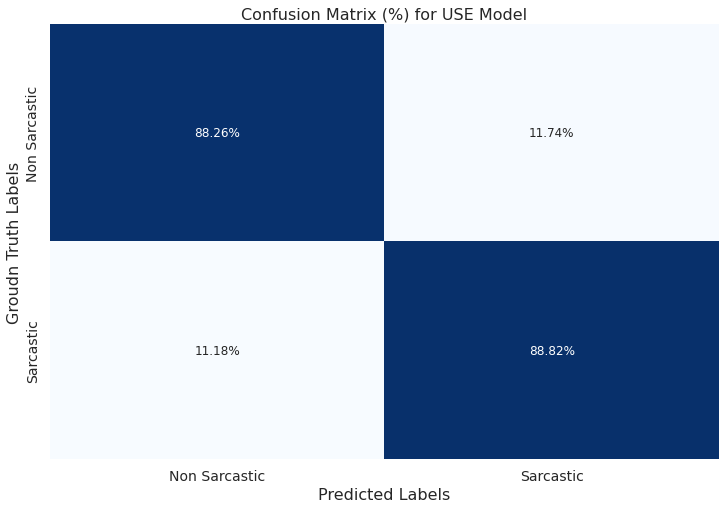

In [109]:
plot_confusion_matrix(y_true = y_valid, y_pred = model_10_predictions, model_name = model_10.name)

Let's call the function and plot ROC curve.

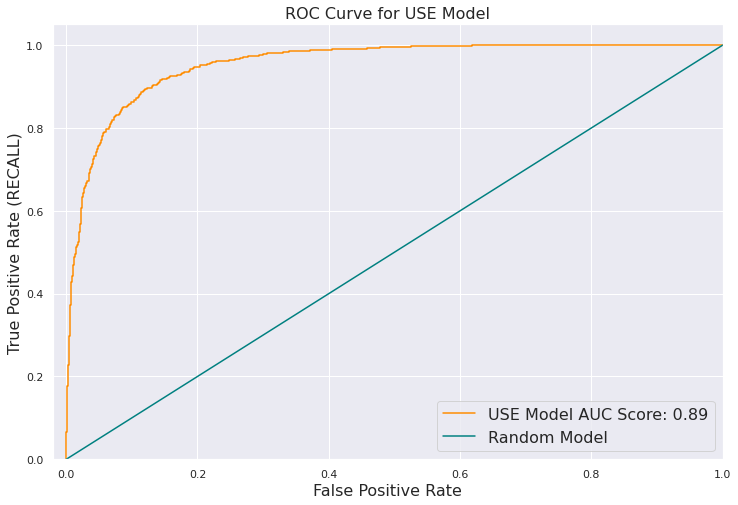

In [110]:
plot_roc_curve(y_true = y_valid, y_pred = model_10_predictions,
               validation_data = X_valid, custom_objects = CUSTOM_OBJECTS,
               model_path = f'{model_10.name}.h5')

Let's call the function and evaluate the performance of the model.

In [111]:
model_10_df = evaluate_model_performance(y_true = y_valid, 
                                         y_pred = model_10_predictions, 
                                         custom_objects = CUSTOM_OBJECTS, 
                                         model_path = f'{model_10.name}.h5')
model_10_df

,Train_Accuracy,Validation_Accuracy,Precision_Score,Recall_Score,AUC_Score,F1_Score
USE Model,0.93,0.89,0.88,0.89,0.89,0.88


Let's define a function to create an ensemble model.

In [112]:
def create_ensemble_model(num_models = 10):
  """
  This is a function that will create a list of models which together form an
  ensemble model.

  Args:
    num_models: The number of models to form an ensemble model.

  Returns:
    A list of models.
  """
  models = []

  for x in range(1, num_models + 1):
    # Cloning the architecture of the LSTM model
    model = clone_model(model = model_6)

    # Compiling the model
    model.compile(optimizer = Adam(), loss = BinaryCrossentropy(), metrics = ['accuracy'])

    # Fitting the model
    model_training = model.fit(train_set, epochs = 500, validation_data = valid_set,
                               callbacks = model_callbacks(model_path = f'Model_{x}.h5', 
                               tolerance = 3, verbosity = 0), verbose = 0)
    # Appending the model
    models.append(model)

  return models

Let's call the function, create a list of models and display the number of models that form the Ensemble model.

In [113]:
models = create_ensemble_model()
print(f'The number of models that form the Ensemble model: {len(models)}')

The number of models that form the Ensemble model: 10


Let's define a function that will load all the models and evaluate their performance on train and validation sets.

In [114]:
def load_evaluate_ensemble(model_instances):
  """
  This is a function that will load and evaluate the performance of all the
  models that form the Ensemble model on train and validation sets.

  Args:
    model_instances: A list of models that form the Ensemble Model.

  Returns:
    Prints out the model performance on train and validation sets.
  """
  train_losses, train_accuracies = [], []
  valid_losses, valid_accuracies = [], []

  for model_path in model_instances:
    model_instance = load_model(filepath = model_path)

    train_loss, train_accuracy = model_instance.evaluate(train_set, verbose = 0)
    valid_loss, valid_accuracy = model_instance.evaluate(valid_set, verbose = 0)

    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

  # Aggregating accuracy for train and validation sets
  aggregated_train_accuracy = np.mean(a = train_accuracies)
  aggregated_valid_accuracy = np.mean(a = valid_accuracies)

  # Aggregating loss for train and validation sets
  aggregated_train_loss = np.mean(a = train_losses)
  aggregated_valid_loss = np.mean(a = valid_losses)

  print(f'Train accuracy for Ensemble model: {aggregated_train_accuracy:.2%}')
  print(f'Validation accuracy for Ensemble model: {aggregated_valid_accuracy:.2%}\n')
  print(f'Train loss for Ensemble model: {aggregated_train_loss:.2f}')
  print(f'Validation loss for Ensemble model: {aggregated_valid_loss:.2f}')

Let's create a list of models that form the Ensemble model and call the function and evalute the model performance on train and validation sets.

In [115]:
models_list = [model for model in os.listdir() if model.startswith('Model_')]
load_evaluate_ensemble(model_instances = models_list)

Train accuracy for Ensemble model: 97.03%
Validation accuracy for Ensemble model: 90.11%

Train loss for Ensemble model: 0.11
Validation loss for Ensemble model: 0.24


Let's load each model in the Ensemble model, make predictions on validation set, aggregate them and call the function to print out the classification report.

In [116]:
models_predictions = []
predictions_probas = []

for model_path in models_list:
  model = load_model(filepath = model_path)
  model_prediction = tf.math.round(x = tf.squeeze(input = model.predict(x = valid_set))).numpy()
  prediction_proba = tf.squeeze(input = model.predict(x = valid_set)).numpy()
  
  models_predictions.append(model_prediction)
  predictions_probas.append(prediction_proba)

aggregated_model_prediction = np.round(a = np.mean(a = models_predictions, axis = 0))
aggregated_prediction_proba = np.mean(a = predictions_probas, axis = 0)

print_model_report(y_true = y_valid, y_pred = aggregated_model_prediction, model_name = 'Ensemble')

Classification report for Ensemble model:


               precision    recall  f1-score   support

Non Sarcastic       0.94      0.88      0.91      1295
    Sarcastic       0.88      0.93      0.90      1207

     accuracy                           0.91      2502
    macro avg       0.91      0.91      0.91      2502
 weighted avg       0.91      0.91      0.91      2502



Let's call the function and plot the confusion matrix using validation features.

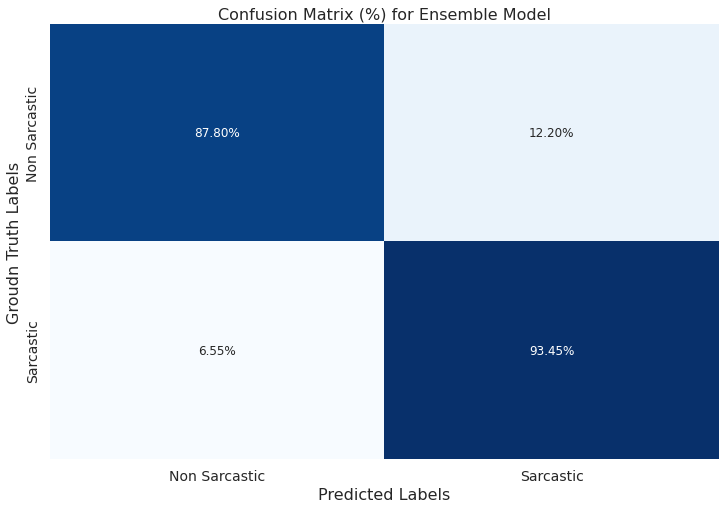

In [117]:
plot_confusion_matrix(y_true = y_valid, y_pred = aggregated_model_prediction, model_name = 'Ensemble')

Let's plot **ROC** curve for the Ensemble model.

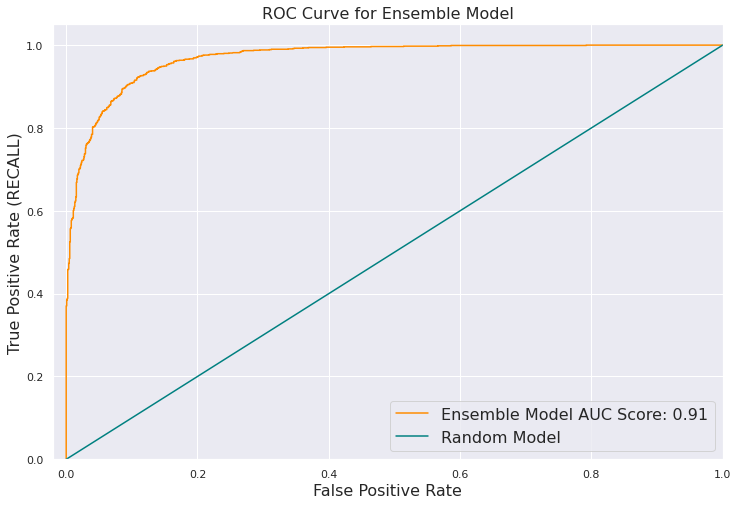

In [118]:
FPR, TPR, THRESHOLDS = roc_curve(y_true = y_valid, y_score = aggregated_prediction_proba)
AUC = roc_auc_score(y_true = y_valid, y_score = aggregated_model_prediction)

plt.plot(FPR, TPR, label = f'Ensemble Model AUC Score: {AUC:.2f}', c = 'darkorange')
plt.plot([0, 1], [0, 1], label = 'Random Model', c = 'teal')
plt.title(label = 'ROC Curve for Ensemble Model', fontsize = 16)
plt.ylabel(ylabel = 'True Positive Rate (RECALL)', fontsize = 16)
plt.xlabel(xlabel = 'False Positive Rate', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

Let's define a function to evaluate the performance of the model and store the metrics in pandas dataframe.

In [119]:
def evaluate_ensemble_model_performance(y_true, y_pred, model_instances):
  """
  This is a function that wil evaluate the performance of the Ensemble model
  using various evaluation metrics for a classification problem such as
  Accuracy, Precision, Recall, F1 Score and AUC.

  Args:
    y_true: Ground truth labels.
    y_pred: Predicted labels.
    model_instances: A list of models that form the Ensemble model.

  Returns:
    A pandas dataframe.
  """
  train_accuracies = []
  valid_accuracies = []

  for model_path in model_instances:
    model_instance = load_model(filepath = model_path)
    
    _, train_accuracy = model_instance.evaluate(train_set, verbose = 0)
    _, valid_accuracy = model_instance.evaluate(valid_set, verbose = 0)

    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

  aggregated_train_accuracy = np.mean(a = train_accuracies)
  aggregated_valid_accuracy = np.mean(a = valid_accuracies)

  precision = precision_score(y_true = y_true, y_pred = y_pred)
  recall = recall_score(y_true = y_true, y_pred = y_pred)
  auc = roc_auc_score(y_true = y_true, y_score = y_pred)
  f1 = f1_score(y_true = y_true, y_pred = y_pred)

  df = pd.DataFrame(columns = COLUMNS, index = ['Ensemble Model'])
  df['Train_Accuracy'] = round(number = aggregated_train_accuracy, ndigits = 2)
  df['Validation_Accuracy'] = round(number = aggregated_valid_accuracy, ndigits = 2)
  df['Precision_Score'] = round(number = precision, ndigits = 2)
  df['Recall_Score'] = round(number = recall, ndigits = 2)
  df['AUC_Score'] = round(number = auc, ndigits = 2)
  df['F1_Score'] = round(number = f1, ndigits = 2)

  return df

Let's call the function and evalute the performance of the Ensemble model.

In [120]:
model_11_df = evaluate_ensemble_model_performance(y_true = y_valid, y_pred = aggregated_model_prediction, model_instances = models_list)
model_11_df

,Train_Accuracy,Validation_Accuracy,Precision_Score,Recall_Score,AUC_Score,F1_Score
Ensemble Model,0.97,0.9,0.88,0.93,0.91,0.9


Let's compare all the models.

In [121]:
models_summary = pd.concat(objs = [model_1_df, model_2_df, model_3_df, model_4_df, model_5_df,
                                   model_6_df, model_7_df, model_8_df, model_9_df, model_10_df,
                                   model_11_df], axis = 0)
models_summary.sort_values(by = 'F1_Score', ascending = False, inplace = True)
models_summary

,Train_Accuracy,Validation_Accuracy,Precision_Score,Recall_Score,AUC_Score,F1_Score
GRU Model,0.97,0.91,0.89,0.93,0.91,0.91
Sequential_Feed_Forward Model,0.98,0.90,0.88,0.91,0.90,0.90
Functional_Feed_Forward Model,0.97,0.90,0.88,0.93,0.90,0.90
LSTM Model,0.97,0.90,0.88,0.92,0.90,0.90
Bidirectional_LSTM Model,0.98,0.90,0.88,0.92,0.90,0.90
Bidirectional_GRU Model,0.97,0.90,0.88,0.93,0.90,0.90
Sequential_Conv1D Model,0.97,0.90,0.88,0.93,0.91,0.90
Functional_Conv1D Model,0.96,0.90,0.88,0.93,0.90,0.90
Ensemble Model,0.97,0.90,0.88,0.93,0.91,0.90
Multinomial Naive Bayes Model,0.96,0.89,0.90,0.86,0.89,0.88


Let's define a function to make predictions on custom data.

In [122]:
def make_predictions(sentence, tokenizer_object, model_path):
  """
  This is a function that makes prediction on custom data.

  Args:
    sentence: A headline sentence for prediction.
    tokenizer_object: A tokenizer instance to tokenize a sequence
    model_path: A path to a model.
  
  Returns:
    Prediction label and probability.
  """
  model = load_model(filepath = model_path)

  sentence_to_list = [sentence]
  tokenized_sentence = tokenizer_object.texts_to_sequences(texts = sentence_to_list)
  padded_sequence = pad_sequences(sequences = tokenized_sentence, maxlen = AVG_SEQUENCE_LENGTH, padding = 'post', truncating = 'post')

  model_prediction = tf.cast(x = tf.math.round(x = tf.squeeze(input = model.predict(x = padded_sequence))), dtype = tf.int32).numpy()
  prediction_proba = tf.squeeze(input = model.predict(x = padded_sequence)).numpy()

  if model_prediction == 1:
    print(f'Input: {sentence} -> Output: Sarcastic Headline with {prediction_proba:.2%} probability')
  else:
    print(f'Input: {sentence} -> Output: Non Sarcastic Headline with {1.0 - prediction_proba:.2%} probability')

Let's create a list of sentences, and make predictions on them.

In [123]:
test_sentences = ['Key takeaways from Week 7 of the Elizabeth Holmes trial',
                  'Anarchists Rise Up, Move To Different Cafeteria Table']

for test_sentence in test_sentences:
  make_predictions(sentence = test_sentence, tokenizer_object = tokenizer,
                   model_path = f'{model_6.name}.h5')

Input: Key takeaways from Week 7 of the Elizabeth Holmes trial -> Output: Non Sarcastic Headline with 89.80% probability
Input: Anarchists Rise Up, Move To Different Cafeteria Table -> Output: Sarcastic Headline with 77.16% probability


Let's save the tokenizer instance and download it along with **GRU** model.

In [124]:
with open(file = 'tokenizer.pkl', mode = 'wb') as f:
  pickle.dump(obj = tokenizer, file = f)

downloadable_files = ['tokenizer.pkl', 'GRU.h5']

for downloadable_file in downloadable_files:
  download(filename = downloadable_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>